In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import yaml
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from datetime import datetime
import warnings
from matplotlib import gridspec
from matplotlib.patches import Polygon
import shap
import lime
import lime.lime_tabular
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torchvision import transforms
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, accuracy_score
import json
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set global font and style
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 11
rcParams['axes.labelsize'] = 11
rcParams['axes.titlesize'] = 12
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Times New Roman'
rcParams['mathtext.it'] = 'Times New Roman:italic'
rcParams['mathtext.bf'] = 'Times New Roman:bold'
rcParams['axes.grid'] = False

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('imed_mdpi_framework.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# ============================================================================
# DIRECTORY MANAGEMENT
# ============================================================================

def ensure_dir(directory):
    """Create directory if it doesn't exist"""
    if not os.path.exists(directory):
        os.makedirs(directory)
        logger.info(f"Created directory: {directory}")

def setup_save_directories(base_dir="MRC-JHR"):
    """Setup all necessary directories for saving results"""
    directories = [
        base_dir,
        os.path.join(base_dir, "plots"),
        os.path.join(base_dir, "data"),
        os.path.join(base_dir, "metrics"),
        os.path.join(base_dir, "predictions"),
        os.path.join(base_dir, "models"),
        os.path.join(base_dir, "domain_analysis"),
        os.path.join(base_dir, "uncertainty"),
        os.path.join(base_dir, "feature_analysis"),
        os.path.join(base_dir, "optimization"),
        os.path.join(base_dir, "convex_hull_analysis"),
        os.path.join(base_dir, "comprehensive_report"),
        os.path.join(base_dir, "config"),
        os.path.join(base_dir, "raw_data"),
        os.path.join(base_dir, "training_history"),
        os.path.join(base_dir, "ensemble_results"),
        os.path.join(base_dir, "latent_sampling"),
        os.path.join(base_dir, "explainability"),
        os.path.join(base_dir, "generation_metrics")
    ]
    for directory in directories:
        ensure_dir(directory)
    return base_dir

# ============================================================================
# COMPREHENSIVE DATA SAVING FUNCTIONS
# ============================================================================

def save_configuration_to_csv(config, save_dir):
    """Save configuration parameters to CSV"""
    config_data = []
    for key, value in config.items():
        config_data.append({
            'Parameter': key,
            'Value': str(value),
            'Type': type(value).__name__
        })
    config_df = pd.DataFrame(config_data)
    filepath = os.path.join(save_dir, "config", "model_configuration.csv")
    config_df.to_csv(filepath, index=False)
    logger.info(f"Configuration saved to CSV: {filepath}")
    return filepath

def save_raw_dataset_info(X, y, feature_names, save_dir):
    """Save raw dataset information to CSV"""
    dataset_info = {
        'Dataset_Info': [
            'Total_Samples',
            'Number_of_Features',
            'Target_Variable',
            'Feature_Names',
            'Target_Mean',
            'Target_Std',
            'Target_Min',
            'Target_Max'
        ],
        'Value': [
            X.shape[0],
            X.shape[1],
            'Manning_Coefficient_n',
            ', '.join(feature_names),
            np.mean(y),
            np.std(y),
            np.min(y),
            np.max(y)
        ]
    }
    info_df = pd.DataFrame(dataset_info)
    filepath = os.path.join(save_dir, "raw_data", "dataset_info.csv")
    info_df.to_csv(filepath, index=False)
    logger.info(f"Dataset info saved to CSV: {filepath}")
    return filepath

def save_data_splits_to_csv(X_train, X_val, X_test, y_train, y_val, y_test, feature_names, save_dir):
    """Save all data splits to individual CSV files"""
    datasets = {
        'train': (X_train, y_train),
        'validation': (X_val, y_val),
        'test': (X_test, y_test)
    }
    saved_files = []
    for split_name, (X, y) in datasets.items():
        if isinstance(X, torch.Tensor):
            X_np = X.cpu().numpy()
        else:
            X_np = X
        if isinstance(y, torch.Tensor):
            y_np = y.cpu().numpy()
        else:
            y_np = y
        df = pd.DataFrame(X_np, columns=feature_names)
        df['Manning_Coefficient_n'] = y_np.flatten()
        df['Data_Split'] = split_name
        df['Sample_Index'] = range(len(df))
        filepath = os.path.join(save_dir, "raw_data", f"{split_name}_data.csv")
        df.to_csv(filepath, index=False)
        saved_files.append(filepath)
        logger.info(f"{split_name.capitalize()} data saved to CSV: {filepath}")
    return saved_files

# ============================================================================
# DNN MODEL SAVING FUNCTIONS
# ============================================================================

def save_dnn_predictions_to_csv(y_true, predictions_array, model_name, save_dir):
    """Save DNN ensemble predictions to CSV"""
    mean_predictions = np.mean(predictions_array, axis=0).flatten()
    std_predictions = np.std(predictions_array, axis=0).flatten()
    dnn_data = []
    for i in range(len(y_true)):
        row = {
            'Sample_Index': i,
            'True_Manning_Coefficient': y_true[i][0] if y_true[i].ndim > 0 else y_true[i],
            'Mean_Prediction': mean_predictions[i],
            'Std_Prediction': std_predictions[i],
            'Relative_Error_Percent': abs((y_true.flatten()[i] - mean_predictions[i]) / y_true.flatten()[i]) * 100
        }
        for j in range(predictions_array.shape[0]):
            row[f'Model_{j+1}_Prediction'] = predictions_array[j][i][0] if predictions_array[j][i].ndim > 0 else predictions_array[j][i]
        dnn_data.append(row)
    df = pd.DataFrame(dnn_data)
    filepath = os.path.join(save_dir, "predictions", f"{model_name.lower()}_detailed_predictions.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"DNN detailed predictions saved to CSV: {filepath}")
    return filepath

def save_dnn_ensemble_statistics_to_csv(y_true, predictions_array, model_name, save_dir):
    """Save DNN ensemble statistics similar to CGAN uncertainty metrics"""
    mean_predictions = np.mean(predictions_array, axis=0)
    std_predictions = np.std(predictions_array, axis=0)
    percentile_2_5 = np.percentile(predictions_array, 2.5, axis=0)
    percentile_97_5 = np.percentile(predictions_array, 97.5, axis=0)
    percentile_25 = np.percentile(predictions_array, 25, axis=0)
    percentile_75 = np.percentile(predictions_array, 75, axis=0)
    median_predictions = np.median(predictions_array, axis=0)
    ensemble_data = []
    for i in range(len(y_true)):
        row = {
            'Sample_Index': i,
            'Mean_Prediction': mean_predictions[i][0] if mean_predictions[i].ndim > 0 else mean_predictions[i],
            'Std_Prediction': std_predictions[i][0] if std_predictions[i].ndim > 0 else std_predictions[i],
            'Coefficient_of_Variation': (std_predictions[i] / (abs(mean_predictions[i]) + 1e-8))[0] if mean_predictions[i].ndim > 0 else (std_predictions[i] / (abs(mean_predictions[i]) + 1e-8)),
            'CI_Lower_2_5': percentile_2_5[i][0] if percentile_2_5[i].ndim > 0 else percentile_2_5[i],
            'CI_Upper_97_5': percentile_97_5[i][0] if percentile_97_5[i].ndim > 0 else percentile_97_5[i],
            'Prediction_Interval': (percentile_97_5[i] - percentile_2_5[i])[0] if percentile_97_5[i].ndim > 0 else (percentile_97_5[i] - percentile_2_5[i]),
            'Median_Prediction': median_predictions[i][0] if median_predictions[i].ndim > 0 else median_predictions[i],
            'Percentile_25': percentile_25[i][0] if percentile_25[i].ndim > 0 else percentile_25[i],
            'Percentile_75': percentile_75[i][0] if percentile_75[i].ndim > 0 else percentile_75[i],
        }
        ensemble_data.append(row)
    df = pd.DataFrame(ensemble_data)
    filepath = os.path.join(save_dir, "ensemble_results", f"{model_name.lower()}_ensemble_statistics.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"DNN ensemble statistics saved to CSV: {filepath}")
    return filepath

def save_dnn_training_history_to_csv(histories, save_dir):
    """Save DNN training history to CSV"""
    all_history_data = []
    for model_idx, history in enumerate(histories):
        for epoch, (train_loss, val_loss) in enumerate(zip(history['train_losses'], history['val_losses'])):
            all_history_data.append({
                'Model_Index': model_idx + 1,
                'Epoch': epoch + 1,
                'Training_Loss': train_loss,
                'Validation_Loss': val_loss
            })
    df = pd.DataFrame(all_history_data)
    filepath = os.path.join(save_dir, "training_history", "dnn_ensemble_training_history.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"DNN training history saved to CSV: {filepath}")
    return filepath

def save_trained_models(dnn_models, cgan_generator, cgan_discriminator, save_dir):
    """Save trained model state dictionaries"""
    models_dir = os.path.join(save_dir, "models")
    ensure_dir(models_dir)
    for i, model in enumerate(dnn_models):
        torch.save(model.state_dict(), os.path.join(models_dir, f"dnn_model_{i+1}.pth"))
    torch.save(cgan_generator.state_dict(), os.path.join(models_dir, "cgan_generator.pth"))
    torch.save(cgan_discriminator.state_dict(), os.path.join(models_dir, "cgan_discriminator.pth"))
    logger.info(f"All trained models saved to: {models_dir}")

# ============================================================================
# RELATIVE ERROR ANALYSIS FUNCTIONS
# ============================================================================

def plot_relative_error_histograms_comparison(y_true_dnn, y_pred_dnn, y_true_cgan, y_pred_cgan, save_dir):
    """Plot relative error histograms for DNN and CGAN"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    dnn_rel_error = np.abs((y_true_dnn.flatten() - y_pred_dnn.flatten()) / y_true_dnn.flatten()) * 100
    cgan_rel_error = np.abs((y_true_cgan.flatten() - y_pred_cgan.flatten()) / y_true_cgan.flatten()) * 100
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    # DNN Relative Error Histogram
    ax1.hist(dnn_rel_error, bins=30, alpha=0.7, color='blue', edgecolor='black', density=True)
    ax1.axvline(np.mean(dnn_rel_error), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(dnn_rel_error):.2f}%')
    ax1.axvline(np.median(dnn_rel_error), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(dnn_rel_error):.2f}%')
    ax1.axvline(5.0, color='green', linestyle=':', linewidth=2, alpha=0.8, label='5% Threshold')
    ax1.set_xlabel(r'Relative Error, $\mathit{E_r}$ (%)', fontsize=11)
    ax1.set_ylabel('Density', fontsize=11)
    ax1.set_title('DNN Ensemble: Relative Error Distribution', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(False)
    # CGAN Relative Error Histogram
    ax2.hist(cgan_rel_error, bins=30, alpha=0.7, color='red', edgecolor='black', density=True)
    ax2.axvline(np.mean(cgan_rel_error), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {np.mean(cgan_rel_error):.2f}%')
    ax2.axvline(np.median(cgan_rel_error), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(cgan_rel_error):.2f}%')
    ax2.axvline(5.0, color='green', linestyle=':', linewidth=2, alpha=0.8, label='5% Threshold')
    ax2.set_xlabel(r'Relative Error, $\mathit{E_r}$ (%)', fontsize=11)
    ax2.set_ylabel('Density', fontsize=11)
    ax2.set_title('CGAN with Latent Sampling: Relative Error Distribution', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(False)
    # Save as JPEG (600 DPI)
    filepath = os.path.join(plots_dir, "comprehensive_relative_error_comparison.jpg")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"Comprehensive relative error comparison saved: {filepath}")

def save_relative_error_statistics_to_csv(dnn_rel_error, cgan_rel_error, save_dir):
    """Save detailed relative error statistics to CSV"""
    stats_data = {
        'Metric': [
            'Mean_Relative_Error_%', 'Median_Relative_Error_%', 'Std_Relative_Error_%',
            'Min_Relative_Error_%', 'Max_Relative_Error_%', 'Q1_Relative_Error_%',
            'Q3_Relative_Error_%', 'Fraction_Above_5_%', 'Fraction_Above_10_%',
            'Fraction_Above_20_%', '95th_Percentile_%', '99th_Percentile_%'
        ],
        'DNN_Ensemble': [
            np.mean(dnn_rel_error), np.median(dnn_rel_error), np.std(dnn_rel_error),
            np.min(dnn_rel_error), np.max(dnn_rel_error), np.percentile(dnn_rel_error, 25),
            np.percentile(dnn_rel_error, 75), np.sum(dnn_rel_error > 5.0) / len(dnn_rel_error),
            np.sum(dnn_rel_error > 10.0) / len(dnn_rel_error), np.sum(dnn_rel_error > 20.0) / len(dnn_rel_error),
            np.percentile(dnn_rel_error, 95), np.percentile(dnn_rel_error, 99)
        ],
        'CGAN_Latent_Sampling': [
            np.mean(cgan_rel_error), np.median(cgan_rel_error), np.std(cgan_rel_error),
            np.min(cgan_rel_error), np.max(cgan_rel_error), np.percentile(cgan_rel_error, 25),
            np.percentile(cgan_rel_error, 75), np.sum(cgan_rel_error > 5.0) / len(cgan_rel_error),
            np.sum(cgan_rel_error > 10.0) / len(cgan_rel_error), np.sum(cgan_rel_error > 20.0) / len(cgan_rel_error),
            np.percentile(cgan_rel_error, 95), np.percentile(cgan_rel_error, 99)
        ]
    }
    df = pd.DataFrame(stats_data)
    filepath = os.path.join(save_dir, "metrics", "relative_error_comprehensive_statistics.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"Relative error statistics saved to CSV: {filepath}")
    return filepath

# ============================================================================
# DNN VISUALIZATION FUNCTIONS
# ============================================================================

def plot_dnn_ensemble_analysis(y_true, predictions_array, model_name, save_dir):
    """Create comprehensive DNN ensemble analysis plots"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    mean_pred = np.mean(predictions_array, axis=0).flatten()
    std_pred = np.std(predictions_array, axis=0).flatten()
    plt.figure(figsize=(14, 10))
    plt.scatter(y_true.flatten(), mean_pred, alpha=0.6, c='blue', s=50, label='Ensemble Mean')
    plt.errorbar(y_true.flatten(), mean_pred, yerr=std_pred, fmt='none', alpha=0.3, color='red', capsize=3, label='±1 Std Dev')
    min_val = min(np.min(y_true), np.min(mean_pred))
    max_val = max(np.max(y_true), np.max(mean_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')
    plt.xlabel('True Manning Coefficient')
    plt.ylabel('Predicted Manning Coefficient')
    plt.title(f'{model_name}: Ensemble Predictions with Uncertainty')
    plt.legend()
    plt.grid(True, alpha=0.3)
    r2 = r2_score(y_true.flatten(), mean_pred)
    rmse_val = rmse(y_true.flatten(), mean_pred)
    mae_val = mae(y_true.flatten(), mean_pred)
    stats_text = f'R² = {r2:.4f}\nRMSE = {rmse_val:.6f}\nMAE = {mae_val:.6f}\nMean Std = {np.mean(std_pred):.6f}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_ensemble_predictions.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"DNN ensemble predictions plot saved: {filepath}")
    plt.show()

def plot_shap_waterfall(shap_values, test_data, feature_names, sample_idx, save_dir, model_name):
    """Plot SHAP Waterfall Plot for a specific sample"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.plots.waterfall(shap.Explanation(values=shap_values[sample_idx],
                                         base_values=shap_values[sample_idx].sum(),
                                         data=test_data[sample_idx],
                                         feature_names=feature_names))
    plt.title(f'{model_name}: SHAP Waterfall Plot - Sample {sample_idx}')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_waterfall_sample_{sample_idx}.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Waterfall Plot for sample {sample_idx} saved: {filepath}")

def plot_shap_force(shap_values, test_data, feature_names, sample_idx, save_dir, model_name):
    """Plot SHAP Force Plot for a specific sample"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.force_plot(shap.Explanation(values=shap_values[sample_idx],
                                     base_values=shap_values[sample_idx].sum(),
                                     data=test_data[sample_idx],
                                     feature_names=feature_names),
                    matplotlib=True)
    plt.title(f'{model_name}: SHAP Force Plot - Sample {sample_idx}')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_force_sample_{sample_idx}.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Force Plot for sample {sample_idx} saved: {filepath}")

def plot_shap_summary(shap_values, test_data, feature_names, save_dir, model_name):
    """Plot SHAP Summary Plot"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.summary_plot(shap_values, test_data, feature_names=feature_names, show=False)
    plt.title(f'{model_name}: SHAP Summary Plot')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_summary_plot.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Summary Plot saved: {filepath}")

def plot_shap_dependence(shap_values, test_data, feature_names, feature_idx, save_dir, model_name):
    """Plot SHAP Dependence Plot for a specific feature"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.dependence_plot(feature_idx, shap_values, test_data, feature_names=feature_names, show=False)
    plt.title(f'{model_name}: SHAP Dependence Plot - {feature_names[feature_idx]}')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_dependence_{feature_names[feature_idx]}.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Dependence Plot for {feature_names[feature_idx]} saved: {filepath}")

def plot_shap_bar(shap_values, feature_names, save_dir, model_name):
    """Plot SHAP Bar Plot for feature importance"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.plots.bar(shap.Explanation(values=np.mean(np.abs(shap_values), axis=0),
                                    base_values=0,
                                    data=None,
                                    feature_names=feature_names))
    plt.title(f'{model_name}: SHAP Feature Importance (Bar Plot)')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_bar_plot.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Bar Plot saved: {filepath}")

def plot_shap_heatmap(shap_values, feature_names, save_dir, model_name):
    """Plot SHAP Heatmap for all samples"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.plots.heatmap(shap.Explanation(values=shap_values,
                                        base_values=np.zeros(shap_values.shape[1]),
                                        data=None,
                                        feature_names=feature_names))
    plt.title(f'{model_name}: SHAP Heatmap')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_heatmap.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Heatmap saved: {filepath}")

def plot_shap_feature_summary(shap_values, test_data, feature_names, save_dir, model_name):
    """Plot SHAP Feature Summary for global feature importance"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.summary_plot(shap_values, test_data, feature_names=feature_names, show=False)
    plt.title(f'{model_name}: SHAP Feature Summary')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_feature_summary.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Feature Summary Plot saved: {filepath}")

def plot_shap_feature_importance(shap_values, feature_names, save_dir, model_name):
    """Plot SHAP Feature Importance Bar Plot for global feature importance"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.summary_plot(shap_values, features=feature_names, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f'{model_name}: SHAP Feature Importance')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_feature_importance.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Feature Importance Plot saved: {filepath}")

def plot_lime_explanation(lime_explanation, sample_idx, feature_names, save_dir, model_name):
    """Plot LIME Explanation for a specific sample"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    fig = lime_explanation.as_pyplot_figure()
    fig.suptitle(f'{model_name}: LIME Explanation - Sample {sample_idx}', fontsize=14)
    lime_filepath = os.path.join(plots_dir, f"{model_name.lower()}_lime_explanation_sample_{sample_idx}.png")
    fig.savefig(lime_filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"LIME Explanation for sample {sample_idx} saved: {lime_filepath}")

# ============================================================================
# METRICS FUNCTIONS
# ============================================================================

def rmse(y_true, y_pred):
    """Root Mean Square Error"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    """Mean Absolute Error"""
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rrmse(y_true, y_pred):
    """Relative Root Mean Square Error"""
    return rmse(y_true, y_pred) / np.mean(y_true) * 100

def calculate_metrics(y_true, y_pred):
    """Calculate all metrics"""
    return {
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'MAPE': mape(y_true, y_pred),
        'rRMSE': rrmse(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# ============================================================================
# PHYSICAL CONSTRAINTS FOR CGAN PREDICTIONS
# ============================================================================

def apply_physical_constraints(predictions, y_true):
    """Apply physical constraints to CGAN predictions by clipping them to the range [min(y_true), max(y_true)]"""
    n_min = np.min(y_true)
    n_max = np.max(y_true)
    logger.info(f"Applying physical constraints: n_min={n_min:.4f}, n_max={n_max:.4f}")
    if predictions.ndim == 1:
        clipped_predictions = np.clip(predictions, n_min, n_max)
    elif predictions.ndim == 2:
        clipped_predictions = np.clip(predictions, n_min, n_max)
    elif predictions.ndim == 3:
        clipped_predictions = np.clip(predictions, n_min, n_max)
    else:
        clipped_predictions = np.clip(predictions, n_min, n_max)
    n_clipped = np.sum((predictions < n_min) | (predictions > n_max))
    logger.info(f"Number of predictions clipped: {n_clipped} out of {predictions.size}")
    return clipped_predictions

# ============================================================================
# LATENT SPACE SAMPLING FUNCTIONS
# ============================================================================

def evaluate_cgan_with_latent_sampling(generator, X_data, y_data, scaler_y, n_samples=500):
    """Evaluate CGAN using latent space sampling for uncertainty quantification"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_data, y_data = X_data.to(device), y_data.to(device)
    logger.info(f"Starting latent space sampling with {n_samples} samples per condition...")
    generator.eval()
    all_predictions = []
    with torch.no_grad():
        for i in range(X_data.shape[0]):
            condition = X_data[i:i+1]
            sample_predictions = []
            for _ in range(n_samples):
                pred = generator(condition)
                sample_predictions.append(pred.cpu().numpy())
            all_predictions.append(np.array(sample_predictions))
    predictions_array = np.array(all_predictions)
    logger.info(f"Generated predictions shape: {predictions_array.shape}")
    y_true = scaler_y.inverse_transform(y_data.cpu().numpy())
    predictions_scaled = np.zeros_like(predictions_array)
    for i in range(predictions_array.shape[0]):
        for j in range(predictions_array.shape[1]):
            predictions_scaled[i, j] = scaler_y.inverse_transform(predictions_array[i, j])
    logger.info("Applying physical constraints to CGAN latent sampling predictions...")
    predictions_scaled = apply_physical_constraints(predictions_scaled, y_true)
    logger.info(f"Latent space sampling completed: {predictions_scaled.shape}")
    return y_true, predictions_scaled

def analyze_ensemble_statistics(predictions_array):
    """Analyze statistical properties of ensemble predictions"""
    logger.info(f"Analyzing ensemble statistics for predictions shape: {predictions_array.shape}")
    mean_predictions = np.mean(predictions_array, axis=1)
    std_predictions = np.std(predictions_array, axis=1)
    percentile_2_5 = np.percentile(predictions_array, 2.5, axis=1)
    percentile_97_5 = np.percentile(predictions_array, 97.5, axis=1)
    coefficient_of_variation = std_predictions / (np.abs(mean_predictions) + 1e-8)
    prediction_intervals = percentile_97_5 - percentile_2_5
    median_predictions = np.median(predictions_array, axis=1)
    percentile_25 = np.percentile(predictions_array, 25, axis=1)
    percentile_75 = np.percentile(predictions_array, 75, axis=1)
    uncertainty_metrics = {
        'mean_predictions': mean_predictions,
        'std_predictions': std_predictions,
        'coefficient_of_variation': coefficient_of_variation,
        'confidence_interval_lower': percentile_2_5,
        'confidence_interval_upper': percentile_97_5,
        'prediction_intervals': prediction_intervals,
        'median_predictions': median_predictions,
        'percentile_25': percentile_25,
        'percentile_75': percentile_75,
        'raw_predictions': predictions_array
    }
    logger.info("Ensemble statistics analysis completed")
    logger.info(f"Mean std deviation: {np.mean(std_predictions):.6f}")
    logger.info(f"Mean prediction interval: {np.mean(prediction_intervals):.6f}")
    logger.info(f"Mean coefficient of variation: {np.mean(coefficient_of_variation):.6f}")
    return uncertainty_metrics

def save_uncertainty_metrics_to_csv(uncertainty_metrics, model_name, save_dir):
    """Save uncertainty metrics to CSV file"""
    flattened_data = []
    n_samples = len(uncertainty_metrics['mean_predictions'])
    for i in range(n_samples):
        row = {
            'Sample_Index': i,
            'Mean_Prediction': uncertainty_metrics['mean_predictions'][i][0] if uncertainty_metrics['mean_predictions'][i].ndim > 0 else uncertainty_metrics['mean_predictions'][i],
            'Std_Prediction': uncertainty_metrics['std_predictions'][i][0] if uncertainty_metrics['std_predictions'][i].ndim > 0 else uncertainty_metrics['std_predictions'][i],
            'Coefficient_of_Variation': uncertainty_metrics['coefficient_of_variation'][i][0] if uncertainty_metrics['coefficient_of_variation'][i].ndim > 0 else uncertainty_metrics['coefficient_of_variation'][i],
            'CI_Lower_2_5': uncertainty_metrics['confidence_interval_lower'][i][0] if uncertainty_metrics['confidence_interval_lower'][i].ndim > 0 else uncertainty_metrics['confidence_interval_lower'][i],
            'CI_Upper_97_5': uncertainty_metrics['confidence_interval_upper'][i][0] if uncertainty_metrics['confidence_interval_upper'][i].ndim > 0 else uncertainty_metrics['confidence_interval_upper'][i],
            'Prediction_Interval': uncertainty_metrics['prediction_intervals'][i][0] if uncertainty_metrics['prediction_intervals'][i].ndim > 0 else uncertainty_metrics['prediction_intervals'][i],
            'Median_Prediction': uncertainty_metrics['median_predictions'][i][0] if uncertainty_metrics['median_predictions'][i].ndim > 0 else uncertainty_metrics['median_predictions'][i],
            'Percentile_25': uncertainty_metrics['percentile_25'][i][0] if uncertainty_metrics['percentile_25'][i].ndim > 0 else uncertainty_metrics['percentile_25'][i],
            'Percentile_75': uncertainty_metrics['percentile_75'][i][0] if uncertainty_metrics['percentile_75'][i].ndim > 0 else uncertainty_metrics['percentile_75'][i],
        }
        flattened_data.append(row)
    df = pd.DataFrame(flattened_data)
    filepath = os.path.join(save_dir, "latent_sampling", f"{model_name.lower()}_uncertainty_metrics.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"Uncertainty metrics saved to CSV: {filepath}")
    return filepath

# ============================================================================
# UNCERTAINTY VISUALIZATION FUNCTIONS
# ============================================================================

def plot_uncertainty_analysis(y_true, uncertainty_metrics, model_name, save_dir):
    """Plot comprehensive uncertainty analysis including confidence intervals"""
    plots_dir = os.path.join(save_dir, "uncertainty")
    ensure_dir(plots_dir)
    mean_pred = uncertainty_metrics['mean_predictions'].flatten()
    std_pred = uncertainty_metrics['std_predictions'].flatten()
    lower_ci = uncertainty_metrics['confidence_interval_lower'].flatten()
    upper_ci = uncertainty_metrics['confidence_interval_upper'].flatten()
    plt.figure(figsize=(14, 10))
    plt.scatter(y_true.flatten(), mean_pred, alpha=0.6, c='blue', s=50, label='Mean Predictions')
    plt.errorbar(y_true.flatten(), mean_pred, yerr=std_pred, fmt='none', alpha=0.3, color='red', capsize=3, label='±1 Std Dev')
    indices = np.argsort(y_true.flatten())
    y_true_sorted = y_true.flatten()[indices]
    mean_pred_sorted = mean_pred[indices]
    lower_ci_sorted = lower_ci[indices]
    upper_ci_sorted = upper_ci[indices]
    plt.fill_between(y_true_sorted, lower_ci_sorted, upper_ci_sorted, alpha=0.2, color='green', label='95% Confidence Interval')
    min_val = min(np.min(y_true), np.min(mean_pred))
    max_val = max(np.max(y_true), np.max(mean_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')
    plt.xlabel('True Manning Coefficient')
    plt.ylabel('Predicted Manning Coefficient')
    plt.title(f'{model_name}: Predictions with Latent Space Uncertainty Quantification')
    plt.legend()
    plt.grid(True, alpha=0.3)
    r2 = r2_score(y_true.flatten(), mean_pred)
    rmse_val = rmse(y_true.flatten(), mean_pred)
    mae_val = mae(y_true.flatten(), mean_pred)
    stats_text = f'R² = {r2:.4f}\nRMSE = {rmse_val:.6f}\nMAE = {mae_val:.6f}\nMean Std = {np.mean(std_pred):.6f}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_uncertainty_predictions.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"Uncertainty predictions plot saved: {filepath}")
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.hist(std_pred, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(np.mean(std_pred), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(std_pred):.6f}')
    plt.axvline(np.median(std_pred), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(std_pred):.6f}')
    plt.xlabel('Prediction Standard Deviation')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: Distribution of Prediction Uncertainties')
    plt.legend()
    plt.grid(True, alpha=0.3)
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_uncertainty_distribution.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"Uncertainty distribution plot saved: {filepath}")
    plt.show()
    plt.figure(figsize=(12, 8))
    cv = uncertainty_metrics['coefficient_of_variation'].flatten()
    plt.hist(cv, bins=30, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(np.mean(cv), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(cv):.4f}')
    plt.axvline(np.median(cv), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(cv):.4f}')
    plt.xlabel('Coefficient of Variation (Std/Mean)')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: Coefficient of Variation Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_coefficient_of_variation.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"Coefficient of variation plot saved: {filepath}")
    plt.show()
    plt.figure(figsize=(12, 8))
    pred_intervals = uncertainty_metrics['prediction_intervals'].flatten()
    plt.hist(pred_intervals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(np.mean(pred_intervals), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(pred_intervals):.6f}')
    plt.axvline(np.median(pred_intervals), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(pred_intervals):.6f}')
    plt.xlabel('95% Prediction Interval Width')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: Prediction Interval Width Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_prediction_intervals.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"Prediction intervals plot saved: {filepath}")
    plt.show()

# ============================================================================
# ENHANCED CONVEX HULL FUNCTIONS
# ============================================================================

def points_in_convex_hull_2d(points, hull):
    """Determine which points are inside a 2D convex hull"""
    try:
        A = hull.equations[:, :-1]
        b = hull.equations[:, -1]
        is_inside = np.all(np.dot(points, A.T) + b <= 1e-12, axis=1)
        return is_inside
    except Exception as e:
        logger.warning(f"Convex hull point classification failed: {e}")
        return np.ones(len(points), dtype=bool)

def pca_convex_hull_analysis_with_uncertainty(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, uncertainty_metrics, model_name, save_dir=None):
    """Enhanced uncertainty quantification using PCA and convex hull analysis"""
    logger.info(f"Performing Enhanced PCA Convex Hull Analysis with Uncertainty for {model_name}...")
    X_train = X_train.cpu().numpy() if isinstance(X_train, torch.Tensor) else X_train
    X_test = X_test.cpu().numpy() if isinstance(X_test, torch.Tensor) else X_test
    y_train = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
    y_test = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test
    logger.info(f"Using COMPLETE test dataset: {X_test.shape[0]} points for convex hull analysis")
    logger.info(f"Training dataset size: {X_train.shape[0]} points (used to create convex hull)")
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    logger.info(f"PCA transformation completed: explained variance ratio: {pca.explained_variance_ratio_}")
    try:
        hull = ConvexHull(X_train_pca)
        hull_points = X_train_pca[hull.vertices]
        logger.info(f"Convex hull created with {len(hull.vertices)} vertices from training data")
        inside_hull_test = points_in_convex_hull_2d(X_test_pca, hull)
        outside_hull_test = ~inside_hull_test
        total_test_points = len(inside_hull_test)
        points_inside = np.sum(inside_hull_test)
        points_outside = np.sum(outside_hull_test)
        logger.info(f"Complete test dataset analysis results: Total={total_test_points}, Inside={points_inside}, Outside={points_outside}")
        y_train_flat = y_train_pred.flatten() if y_train_pred.ndim > 1 else y_train_pred
        y_test_flat = y_test_pred.flatten() if y_test_pred.ndim > 1 else y_test_pred
        y_train_true_flat = y_train.flatten()
        y_test_true_flat = y_test.flatten()
        train_rel_error = np.abs((y_train_true_flat - y_train_flat) / y_train_true_flat) * 100
        test_rel_error = np.abs((y_test_true_flat - y_test_flat) / y_test_true_flat) * 100
        test_rel_error_inside = test_rel_error[inside_hull_test]
        test_rel_error_outside = test_rel_error[outside_hull_test]
        y_test_true_inside = y_test_true_flat[inside_hull_test]
        y_test_pred_inside = y_test_flat[inside_hull_test]
        y_test_true_outside = y_test_true_flat[outside_hull_test]
        y_test_pred_outside = y_test_flat[outside_hull_test]
        std_predictions_inside = uncertainty_metrics['std_predictions'].flatten()[inside_hull_test]
        std_predictions_outside = uncertainty_metrics['std_predictions'].flatten()[outside_hull_test]
        cv_inside = uncertainty_metrics['coefficient_of_variation'].flatten()[inside_hull_test]
        cv_outside = uncertainty_metrics['coefficient_of_variation'].flatten()[outside_hull_test]
        def calculate_fraction_above_5pct(rel_errors):
            return np.sum(rel_errors > 5.0) / len(rel_errors) if len(rel_errors) > 0 else np.nan
        def calculate_r2_safe(y_true, y_pred):
            if len(y_true) == 0 or np.var(y_true) == 0:
                return np.nan
            return r2_score(y_true, y_pred)
        def calculate_mean_safe(values):
            return np.mean(values) if len(values) > 0 else np.nan
        stats_results = {
            'train_mean_rel_error': np.mean(train_rel_error),
            'train_std_rel_error': np.std(train_rel_error),
            'train_max_rel_error': np.max(train_rel_error),
            'train_fraction_above_5pct': calculate_fraction_above_5pct(train_rel_error),
            'train_r2': calculate_r2_safe(y_train_true_flat, y_train_flat),
            'test_inside_mean_rel_error': np.mean(test_rel_error_inside) if len(test_rel_error_inside) > 0 else np.nan,
            'test_inside_std_rel_error': np.std(test_rel_error_inside) if len(test_rel_error_inside) > 0 else np.nan,
            'test_inside_max_rel_error': np.max(test_rel_error_inside) if len(test_rel_error_inside) > 0 else np.nan,
            'test_inside_fraction_above_5pct': calculate_fraction_above_5pct(test_rel_error_inside),
            'test_inside_r2': calculate_r2_safe(y_test_true_inside, y_test_pred_inside),
            'test_inside_mean_uncertainty': calculate_mean_safe(std_predictions_inside),
            'test_inside_mean_cv': calculate_mean_safe(cv_inside),
            'test_outside_mean_rel_error': np.mean(test_rel_error_outside) if len(test_rel_error_outside) > 0 else np.nan,
            'test_outside_std_rel_error': np.std(test_rel_error_outside) if len(test_rel_error_outside) > 0 else np.nan,
            'test_outside_max_rel_error': np.max(test_rel_error_outside) if len(test_rel_error_outside) > 0 else np.nan,
            'test_outside_fraction_above_5pct': calculate_fraction_above_5pct(test_rel_error_outside),
            'test_outside_r2': calculate_r2_safe(y_test_true_outside, y_test_pred_outside),
            'test_outside_mean_uncertainty': calculate_mean_safe(std_predictions_outside),
            'test_outside_mean_cv': calculate_mean_safe(cv_outside),
            'test_overall_mean_rel_error': np.mean(test_rel_error),
            'test_overall_std_rel_error': np.std(test_rel_error),
            'test_overall_max_rel_error': np.max(test_rel_error),
            'test_overall_fraction_above_5pct': calculate_fraction_above_5pct(test_rel_error),
            'test_overall_r2': calculate_r2_safe(y_test_true_flat, y_test_flat),
            'test_overall_mean_uncertainty': np.mean(uncertainty_metrics['std_predictions'].flatten()),
            'test_overall_mean_cv': np.mean(uncertainty_metrics['coefficient_of_variation'].flatten()),
            'total_test_points_analyzed': total_test_points,
            'points_inside_hull': points_inside,
            'points_outside_hull': points_outside,
            'inside_hull_ratio': points_inside / total_test_points,
            'outside_hull_ratio': points_outside / total_test_points,
            'pca_explained_variance_1': pca.explained_variance_ratio_[0],
            'pca_explained_variance_2': pca.explained_variance_ratio_[1],
            'total_explained_variance': np.sum(pca.explained_variance_ratio_)
        }
        print("\n" + "="*80)
        print(f"COMPLETE TEST DATASET CONVEX HULL ANALYSIS WITH UNCERTAINTY - {model_name}")
        print("="*80)
        print(f"Training data size: {len(X_train_pca)} points (used to create convex hull)")
        print(f"Test data size: {total_test_points} points (ALL analyzed)")
        print(f"Points inside hull: {points_inside} ({points_inside/total_test_points*100:.1f}%)")
        print(f"Points outside hull: {points_outside} ({points_outside/total_test_points*100:.1f}%)")
        print(f"PCA explained variance: {np.sum(pca.explained_variance_ratio_):.3f}")
        print(f"Overall mean uncertainty: {stats_results['test_overall_mean_uncertainty']:.6f}")
        print("="*80)
        if save_dir:
            logger.info(f"Creating enhanced plots with uncertainty for complete test dataset analysis ({model_name})...")
            plot_enhanced_convex_hull_with_uncertainty(
                X_train_pca, X_test_pca, hull_points, inside_hull_test,
                uncertainty_metrics, model_name, pca, stats_results, save_dir
            )
            save_complete_convex_hull_stats_to_csv(stats_results, model_name, save_dir)
        return (stats_results, pca, hull, inside_hull_test, outside_hull_test,
                train_rel_error, test_rel_error_inside, test_rel_error_outside, uncertainty_metrics)
    except Exception as e:
        logger.error(f"Complete test dataset convex hull analysis failed for {model_name}: {e}")
        return None, None, None, None, None, None, None, None, None

def plot_enhanced_convex_hull_with_uncertainty(X_train_pca, X_test_pca, hull_points, inside_hull_test, uncertainty_metrics, model_name, pca, stats_results, save_dir):
    """Plot enhanced convex hull analysis with uncertainty information"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure(figsize=(16, 12))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='blue', alpha=0.6, s=30, label=f'Training Data ({len(X_train_pca)} points)')
    X_test_inside = X_test_pca[inside_hull_test]
    X_test_outside = X_test_pca[~inside_hull_test]
    uncertainty_inside = uncertainty_metrics['std_predictions'].flatten()[inside_hull_test]
    uncertainty_outside = uncertainty_metrics['std_predictions'].flatten()[~inside_hull_test]
    total_test_points = len(X_test_pca)
    points_inside = len(X_test_inside)
    points_outside = len(X_test_outside)
    if len(X_test_inside) > 0:
        scatter_inside = plt.scatter(X_test_inside[:, 0], X_test_inside[:, 1], c=uncertainty_inside, cmap='Greens', s=60, marker='s', alpha=0.8, edgecolors='black', linewidth=0.5, label=f'Test Inside Hull ({points_inside}/{total_test_points})')
        plt.colorbar(scatter_inside, label='Uncertainty (Std Dev) - Inside Hull', shrink=0.8)
    if len(X_test_outside) > 0:
        scatter_outside = plt.scatter(X_test_outside[:, 0], X_test_outside[:, 1], c=uncertainty_outside, cmap='Reds', s=60, marker='^', alpha=0.8, edgecolors='black', linewidth=0.5, label=f'Test Outside Hull ({points_outside}/{total_test_points})')
        if len(X_test_inside) == 0:
            plt.colorbar(scatter_outside, label='Uncertainty (Std Dev) - Outside Hull', shrink=0.8)
    hull_polygon = Polygon(hull_points, fill=False, edgecolor='black', linewidth=2, linestyle='--')
    plt.gca().add_patch(hull_polygon)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} explained variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} explained variance)')
    plt.title(f'{model_name}: Convex Hull Analysis with Latent Space Uncertainty\nColor intensity represents prediction uncertainty (std dev)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    textstr = f'LATENT SPACE UNCERTAINTY ANALYSIS\nTotal Test Points: {total_test_points}\nInside Hull: {points_inside} (Avg Unc: {stats_results.get("test_inside_mean_uncertainty", 0):.6f})\nOutside Hull: {points_outside} (Avg Unc: {stats_results.get("test_outside_mean_uncertainty", 0):.6f})\nOverall Avg Uncertainty: {stats_results["test_overall_mean_uncertainty"]:.6f}'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props, fontweight='bold')
    plt.tight_layout()
    filename = f"{model_name.lower()}_convex_hull_with_uncertainty.png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"Convex hull with uncertainty visualization saved: {filepath}")
    plt.show()

def save_complete_convex_hull_stats_to_csv(stats_results, model_name, save_dir):
    """Save complete convex hull statistics with emphasis on full test dataset usage"""
    df = pd.DataFrame([stats_results])
    df.insert(0, 'Model', model_name)
    df.insert(1, 'Analysis_Type', 'Complete_Test_Dataset_Convex_Hull_With_Uncertainty')
    df.insert(2, 'Test_Points_Coverage', 'All_Test_Data_Used_With_Latent_Sampling')
    filepath = os.path.join(save_dir, "convex_hull_analysis", f"{model_name.lower()}_complete_test_convex_hull_uncertainty_stats.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"Complete test dataset convex hull with uncertainty statistics saved: {filepath}")
    return filepath

# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

class EnhancedDNN(nn.Module):
    def __init__(self, input_dim, layers, activation='ReLU', dropout=0.1):
        super(EnhancedDNN, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        prev = input_dim
        for i, h in enumerate(layers):
            self.layers.append(nn.Linear(prev, h))
            if i < len(layers) - 1:
                self.batch_norms.append(nn.BatchNorm1d(h))
                self.dropouts.append(nn.Dropout(dropout))
            prev = h
        self.output_layer = nn.Linear(prev, 1)
        self.activation = getattr(nn, activation)()
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        identity = x
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.batch_norms[i](x)
                x = self.activation(x)
                x = self.dropouts[i](x)
                if x.shape == identity.shape:
                    x = x + identity
                identity = x
        x = self.output_layer(x)
        return x

class EnhancedGenerator(nn.Module):
    def __init__(self, input_dim, noise_dim=20):
        super(EnhancedGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.input_layer = nn.Linear(input_dim + noise_dim, 256)
        self.hidden1 = nn.Linear(256, 512)
        self.hidden2 = nn.Linear(512, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.hidden4 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        z = torch.randn(x.size(0), self.noise_dim, device=x.device)
        input_combined = torch.cat([x, z], dim=1)
        out = self.relu(self.bn1(self.input_layer(input_combined)))
        out = self.dropout(out)
        out = self.relu(self.bn2(self.hidden1(out)))
        out = self.dropout(out)
        out = self.relu(self.bn3(self.hidden2(out)))
        out = self.dropout(out)
        out = self.relu(self.bn4(self.hidden3(out)))
        out = self.dropout(out)
        out = self.relu(self.bn5(self.hidden4(out)))
        out = self.dropout(out)
        raw_output = self.output_layer(out)
        return raw_output

class EnhancedDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

# ============================================================================
# TRAINING UTILITIES
# ============================================================================

class EarlyStopping:
    def __init__(self, patience=50, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

def load_and_prepare_data(csv_path, validation_split=0.2):
    try:
        df = pd.read_csv(csv_path)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values.reshape(-1, 1)
        logger.info(f"Manning coefficient data loaded: {X.shape[0]} samples, {X.shape[1]} features")
        logger.info(f"Manning coefficient n range: min={np.min(y):.4f}, max={np.max(y):.4f}")
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
        X_scaled = scaler_x.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y)
        X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=validation_split, random_state=42)
        tensors = [torch.FloatTensor(arr) for arr in [X_train, X_val, X_test, y_train, y_val, y_test]]
        logger.info("Manning coefficient data preprocessing completed.")
        return tensors, scaler_x, scaler_y
    except FileNotFoundError:
        logger.error("Error: Could not find the Manning coefficient data file. Please check the path.")
        raise
    except Exception as e:
        logger.error(f"Error loading Manning coefficient data: {e}")
        raise

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_dnn_ensemble(models, X_train, y_train, X_val, y_val, config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Training DNN ensemble for Manning coefficient prediction on device: {device}")
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)
    histories = []
    for i, model in enumerate(models):
        logger.info(f"Training DNN model {i+1}/{len(models)}")
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=config['lr_dnn'], weight_decay=config['weight_decay'])
        scheduler = StepLR(optimizer, step_size=config['dnn_lr_schedule_step'], gamma=config['dnn_lr_gamma'])
        early_stopping = EarlyStopping(patience=config['early_stopping_patience'], delta=config['early_stopping_delta'])
        criterion = torch.nn.MSELoss()
        train_losses = []
        val_losses = []
        for epoch in range(config['epochs_dnn']):
            model.train()
            optimizer.zero_grad()
            train_pred = model(X_train)
            train_loss = criterion(train_pred, y_train)
            train_loss.backward()
            optimizer.step()
            scheduler.step()
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val)
                val_loss = criterion(val_pred, y_val)
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
            if early_stopping(val_loss.item(), model):
                model.load_state_dict(early_stopping.best_model)
                logger.info(f"Early stopping at epoch {epoch+1}")
                break
            if (epoch + 1) % 100 == 0:
                logger.info(f"Model {i+1}, Epoch {epoch+1}: Train={train_loss.item():.6f}, Val={val_loss.item():.6f}")
        histories.append({'train_losses': train_losses, 'val_losses': val_losses})
    return histories

def train_single_cgan_for_latent_sampling(generator, discriminator, X_train, y_train, X_val, y_val, config):
    """Train a single CGAN model that will be used for latent space sampling"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Training single CGAN for latent sampling on device: {device}")
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)
    generator.to(device)
    discriminator.to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=config['lr_gan'], betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=config['lr_gan'], betas=(0.5, 0.999))
    scheduler_G = ReduceLROnPlateau(optimizer_G, mode='min', factor=config['lr_scheduler_factor'], patience=config['lr_scheduler_patience'])
    scheduler_D = ReduceLROnPlateau(optimizer_D, mode='min', factor=config['lr_scheduler_factor'], patience=config['lr_scheduler_patience'])
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'], delta=config['early_stopping_delta'])
    losses_D, losses_G, val_losses = [], [], []
    for epoch in range(config['epochs_gan']):
        generator.train()
        discriminator.train()
        batch_size = X_train.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        optimizer_D.zero_grad()
        D_real = discriminator(X_train, y_train)
        loss_D_real = torch.nn.BCELoss()(D_real, real_labels)
        fake_y = generator(X_train).detach()
        D_fake = discriminator(X_train, fake_y)
        loss_D_fake = torch.nn.BCELoss()(D_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()
        optimizer_G.zero_grad()
        fake_y = generator(X_train)
        D_fake = discriminator(X_train, fake_y)
        loss_G = torch.nn.BCELoss()(D_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()
        generator.eval()
        with torch.no_grad():
            val_pred = generator(X_val)
            val_loss = torch.nn.MSELoss()(val_pred, y_val).item()
            val_losses.append(val_loss)
        losses_D.append(loss_D.item())
        losses_G.append(loss_G.item())
        scheduler_G.step(val_loss)
        scheduler_D.step(loss_D.item())
        if early_stopping(val_loss, generator):
            generator.load_state_dict(early_stopping.best_model)
            logger.info(f"Early stopping at epoch {epoch+1}")
            break
        if (epoch + 1) % 100 == 0:
            logger.info(f"Epoch {epoch+1}: D={loss_D.item():.6f}, G={loss_G.item():.6f}, Val={val_loss:.6f}")
    history = {'losses_D': losses_D, 'losses_G': losses_G, 'val_losses': val_losses}
    return generator, discriminator, history

# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

def evaluate_ensemble(models, X_data, y_data, scaler_y, model_type='DNN'):
    """Evaluate ensemble of models and return predictions"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_data, y_data = X_data.to(device), y_data.to(device)
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(X_data)
            predictions.append(pred.cpu().numpy())
    predictions = np.array(predictions)
    y_true = scaler_y.inverse_transform(y_data.cpu().numpy())
    predictions_scaled = np.array([scaler_y.inverse_transform(pred) for pred in predictions])
    if model_type == 'CGAN':
        logger.info("Applying physical constraints to CGAN predictions...")
        predictions_scaled = apply_physical_constraints(predictions_scaled, y_true)
        logger.info("Physical constraints applied to CGAN predictions")
    return y_true, predictions_scaled

# ============================================================================
# NEW EVALUATION METRICS
# ============================================================================

def intra_class_diversity(samples, conditions, metric='variance'):
    """Compute intra-class diversity"""
    unique_conditions = np.unique(conditions)
    diversity_scores = {}
    for cond in unique_conditions:
        cond_samples = samples[conditions == cond]
        if metric == 'variance':
            diversity_scores[cond] = np.var(cond_samples, axis=0).mean()
        elif metric == 'pairwise_distance':
            distances = []
            for i in range(len(cond_samples)):
                for j in range(i+1, len(cond_samples)):
                    distances.append(np.linalg.norm(cond_samples[i] - cond_samples[j]))
            diversity_scores[cond] = np.mean(distances)
    return diversity_scores

def inter_class_separation(samples, conditions, n_components=2):
    """Compute inter-class separation using t-SNE"""
    tsne = TSNE(n_components=n_components)
    embedded = tsne.fit_transform(samples)
    plt.scatter(embedded[:, 0], embedded[:, 1], c=conditions, cmap='viridis')
    plt.title('t-SNE: Inter-class Separation')
    plt.colorbar()
    plt.savefig('inter_class_separation.png')
    plt.close()
    separation_score = silhouette_score(embedded, conditions)
    return separation_score

# ============================================================================
# COMPREHENSIVE EVALUATION WITH LATENT SPACE SAMPLING
# ============================================================================

def comprehensive_evaluation_with_latent_sampling(dnn_models, cgan_generator, X_train, y_train, X_test, y_test, scaler_x, scaler_y, save_dir, config):
    """Enhanced comprehensive evaluation with latent space sampling for CGAN uncertainty quantification"""
    logger.info("Starting Enhanced Evaluation with Latent Space Sampling...")
    # Evaluate DNN models (traditional ensemble)
    logger.info("Evaluating DNN Ensemble...")
    y_train_true_dnn, y_train_pred_dnn = evaluate_ensemble(dnn_models, X_train, y_train, scaler_y, 'DNN')
    y_test_true_dnn, y_test_pred_dnn = evaluate_ensemble(dnn_models, X_test, y_test, scaler_y, 'DNN')
    y_train_pred_dnn_mean = np.mean(y_train_pred_dnn, axis=0)
    y_test_pred_dnn_mean = np.mean(y_test_pred_dnn, axis=0)
    save_dnn_predictions_to_csv(y_test_true_dnn, y_test_pred_dnn, 'DNN_Test', save_dir)
    save_dnn_predictions_to_csv(y_train_true_dnn, y_train_pred_dnn, 'DNN_Train', save_dir)
    save_dnn_ensemble_statistics_to_csv(y_test_true_dnn, y_test_pred_dnn, 'DNN_Test', save_dir)
    save_dnn_ensemble_statistics_to_csv(y_train_true_dnn, y_train_pred_dnn, 'DNN_Train', save_dir)
    plot_dnn_ensemble_analysis(y_test_true_dnn, y_test_pred_dnn, 'DNN_Test', save_dir)
    plot_dnn_ensemble_analysis(y_train_true_dnn, y_train_pred_dnn, 'DNN_Train', save_dir)
    # Evaluate CGAN with latent space sampling
    logger.info(f"Evaluating CGAN with Latent Space Sampling ({config.get('latent_sampling_size', 500)} samples per condition)...")
    y_train_true_cgan, train_predictions_array = evaluate_cgan_with_latent_sampling(
        cgan_generator, X_train, y_train, scaler_y, n_samples=config.get('latent_sampling_size', 500))
    y_test_true_cgan, test_predictions_array = evaluate_cgan_with_latent_sampling(
        cgan_generator, X_test, y_test, scaler_y, n_samples=config.get('latent_sampling_size', 500))
    # Analyze uncertainty from latent space sampling
    logger.info("Analyzing uncertainty statistics from latent space sampling...")
    train_uncertainty = analyze_ensemble_statistics(train_predictions_array)
    test_uncertainty = analyze_ensemble_statistics(test_predictions_array)
    y_train_pred_cgan_mean = train_uncertainty['mean_predictions']
    y_test_pred_cgan_mean = test_uncertainty['mean_predictions']
    # Calculate traditional metrics
    metrics_results = {
        'DNN_Train': calculate_metrics(y_train_true_dnn, y_train_pred_dnn_mean),
        'DNN_Test': calculate_metrics(y_test_true_dnn, y_test_pred_dnn_mean),
        'CGAN_Train': calculate_metrics(y_train_true_cgan, y_train_pred_cgan_mean.flatten()),
        'CGAN_Test': calculate_metrics(y_test_true_cgan, y_test_pred_cgan_mean.flatten())
    }
    print("\n" + "="*80)
    print("MANNING COEFFICIENT PREDICTION - TRADITIONAL METRICS WITH LATENT SAMPLING")
    print("="*80)
    metrics_df = pd.DataFrame(metrics_results).T
    print(metrics_df.round(4))
    # Save uncertainty metrics
    save_uncertainty_metrics_to_csv(train_uncertainty, 'CGAN_Train', save_dir)
    save_uncertainty_metrics_to_csv(test_uncertainty, 'CGAN_Test', save_dir)
    # Create uncertainty visualizations
    logger.info("Creating uncertainty analysis plots...")
    plot_uncertainty_analysis(y_train_true_cgan, train_uncertainty, 'CGAN_Train', save_dir)
    plot_uncertainty_analysis(y_test_true_cgan, test_uncertainty, 'CGAN_Test', save_dir)
    # Create comprehensive relative error comparison
    logger.info("Creating comprehensive relative error histogram comparison...")
    plot_relative_error_histograms_comparison(
        y_test_true_dnn, y_test_pred_dnn_mean,
        y_test_true_cgan, y_test_pred_cgan_mean,
        save_dir
    )
    # Enhanced Convex Hull Analysis with Uncertainty Integration
    logger.info("Performing Enhanced Convex Hull Analysis with Uncertainty Integration...")
    (dnn_hull_stats, dnn_pca, dnn_hull, dnn_inside, dnn_outside,
     dnn_train_rel_error, dnn_test_rel_error_inside, dnn_test_rel_error_outside, _) = pca_convex_hull_analysis_with_uncertainty(
        X_train, X_test, y_train_true_dnn, y_test_true_dnn,
        y_train_pred_dnn_mean, y_test_pred_dnn_mean,
        {'std_predictions': np.zeros_like(y_test_pred_dnn_mean),
         'coefficient_of_variation': np.zeros_like(y_test_pred_dnn_mean)},
        'DNN', save_dir
    )
    (cgan_hull_stats, cgan_pca, cgan_hull, cgan_inside, cgan_outside,
     cgan_train_rel_error, cgan_test_rel_error_inside, cgan_test_rel_error_outside, cgan_uncertainty_results) = pca_convex_hull_analysis_with_uncertainty(
        X_train, X_test, y_train_true_cgan, y_test_true_cgan,
        y_train_pred_cgan_mean.flatten(), y_test_pred_cgan_mean.flatten(),
        test_uncertainty, 'CGAN_with_Latent_Sampling', save_dir
    )
    # Print Enhanced Results
    print("\n" + "="*80)
    print("ENHANCED CONVEX HULL ANALYSIS WITH LATENT SPACE UNCERTAINTY")
    print("ALL TEST POINTS ANALYZED WITH UNCERTAINTY QUANTIFICATION")
    print("="*80)
    if dnn_hull_stats and cgan_hull_stats:
        hull_comparison_df = pd.DataFrame({
            'DNN_Traditional': dnn_hull_stats,
            'CGAN_Latent_Sampling': cgan_hull_stats
        }).T
        print(hull_comparison_df.round(4))
        print("\n" + "="*60)
        print("LATENT SPACE UNCERTAINTY ANALYSIS")
        print("="*60)
        print(f"CGAN Test Overall Mean Uncertainty: {cgan_hull_stats['test_overall_mean_uncertainty']:.6f}")
        print(f"CGAN Test Inside Hull Mean Uncertainty: {cgan_hull_stats.get('test_inside_mean_uncertainty', 'N/A')}")
        print(f"CGAN Test Outside Hull Mean Uncertainty: {cgan_hull_stats.get('test_outside_mean_uncertainty', 'N/A')}")
        print(f"CGAN Test Overall Mean CV: {cgan_hull_stats['test_overall_mean_cv']:.6f}")
        print("="*60)
        hull_comparison_df.to_csv(os.path.join(save_dir, "convex_hull_analysis", "comprehensive_hull_with_latent_sampling.csv"))
        logger.info("Comprehensive convex hull with latent sampling results saved to CSV")
        create_comprehensive_summary_report_with_uncertainty(
            metrics_results, dnn_hull_stats, cgan_hull_stats, test_uncertainty, save_dir
        )
    return metrics_results, dnn_hull_stats, cgan_hull_stats, test_uncertainty

def create_comprehensive_summary_report_with_uncertainty(metrics_results, dnn_hull_stats, cgan_hull_stats, test_uncertainty, save_dir):
    """Create a comprehensive summary report including latent space uncertainty analysis"""
    report_content = f"""
# COMPREHENSIVE MANNING COEFFICIENT PREDICTION WITH LATENT SPACE UNCERTAINTY
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
## TRADITIONAL METRICS SUMMARY
{'='*60}
"""
    for model_split, metrics in metrics_results.items():
        report_content += f"\n{model_split}:\n"
        for metric, value in metrics.items():
            report_content += f"  {metric}: {value:.4f}\n"
    report_content += f"""
## LATENT SPACE UNCERTAINTY QUANTIFICATION SUMMARY
{'='*60}
### CGAN Latent Space Sampling Results:
- Mean Prediction Uncertainty: {np.mean(test_uncertainty['std_predictions']):.6f}
- Median Prediction Uncertainty: {np.median(test_uncertainty['std_predictions']):.6f}
- Mean Coefficient of Variation: {np.mean(test_uncertainty['coefficient_of_variation']):.6f}
- Mean 95% Prediction Interval Width: {np.mean(test_uncertainty['prediction_intervals']):.6f}
### Convex Hull Analysis with Uncertainty:
- Overall Mean Uncertainty: {cgan_hull_stats['test_overall_mean_uncertainty']:.6f}
- Inside Hull Mean Uncertainty: {cgan_hull_stats.get('test_inside_mean_uncertainty', 'N/A')}
- Outside Hull Mean Uncertainty: {cgan_hull_stats.get('test_outside_mean_uncertainty', 'N/A')}
### DNN vs CGAN Comparison:
- DNN Test R²: {metrics_results['DNN_Test']['R2']:.4f}
- CGAN Test R² (with uncertainty): {metrics_results['CGAN_Test']['R2']:.4f}
- CGAN provides {len(test_uncertainty['raw_predictions'][0])} samples per prediction for uncertainty quantification
## DOMAIN ANALYSIS SUMMARY
{'='*60}
- Total Test Points: {cgan_hull_stats['total_test_points_analyzed']}
- Points Inside Hull: {cgan_hull_stats['points_inside_hull']} ({cgan_hull_stats['inside_hull_ratio']*100:.1f}%)
- Points Outside Hull: {cgan_hull_stats['points_outside_hull']} ({cgan_hull_stats['outside_hull_ratio']*100:.1f}%)
- PCA Explained Variance: {cgan_hull_stats['total_explained_variance']:.3f}
"""
    report_path = os.path.join(save_dir, "comprehensive_report", "latent_sampling_analysis_report.txt")
    with open(report_path, 'w') as f:
        f.write(report_content)
    logger.info(f"Comprehensive latent sampling analysis report saved: {report_path}")
    return report_path

# ============================================================================
# EXPLAINABILITY AND FEATURE IMPORTANCE FUNCTIONS (OPTIMIZED)
# ============================================================================

def perform_shap_analysis_optimized(model, X_test, X_train, feature_names, save_dir, model_name="DNN", background_size=100, test_size=200):
    """Perform SHAP analysis for feature importance and explainability"""
    plots_dir = os.path.join(save_dir, "plots")
    explainability_dir = os.path.join(save_dir, "explainability")
    os.makedirs(plots_dir, exist_ok=True)
    os.makedirs(explainability_dir, exist_ok=True)
    logger.info(f"Starting SHAP analysis for {model_name}...")
    model.eval()
    X_test_np = X_test.cpu().numpy()
    X_train_np = X_train.cpu().numpy()
    def model_predict_shap(input_data):
        """Wrapper for SHAP to predict using the PyTorch model."""
        model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(input_data)
            predictions = model(input_tensor).cpu().numpy()
        return predictions.flatten()
    background_indices = np.random.choice(X_train_np.shape[0], min(background_size, X_train_np.shape[0]), replace=False)
    background_data = X_train_np[background_indices]
    explainer = shap.KernelExplainer(model_predict_shap, background_data)
    test_indices = np.random.choice(X_test_np.shape[0], min(test_size, X_test_np.shape[0]), replace=False)
    test_data = X_test_np[test_indices]
    shap_values = explainer.shap_values(test_data, nsamples="auto")
    # Save SHAP values to CSV
    shap_df = pd.DataFrame(shap_values, columns=[f'SHAP_{name}' for name in feature_names])
    for i, name in enumerate(feature_names):
        shap_df[f'Feature_{name}'] = test_data[:, i]
    shap_df['Sample_Index'] = range(len(shap_values))
    shap_filepath = os.path.join(explainability_dir, f"{model_name.lower()}_shap_values.csv")
    shap_df.to_csv(shap_filepath, index=False)
    # Save feature importance summary
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean_Absolute_SHAP': mean_abs_shap,
        'Importance_Rank': np.argsort(mean_abs_shap)[::-1] + 1
    }).sort_values('Mean_Absolute_SHAP', ascending=False)
    importance_filepath = os.path.join(explainability_dir, f"{model_name.lower()}_feature_importance_shap.csv")
    importance_df.to_csv(importance_filepath, index=False)
    # Generate SHAP plots
    plot_shap_summary(shap_values, test_data, feature_names, save_dir, model_name)
    plot_shap_bar(shap_values, feature_names, save_dir, model_name)
    plot_shap_heatmap(shap_values, feature_names, save_dir, model_name)
    plot_shap_feature_summary(shap_values, test_data, feature_names, save_dir, model_name)
    plot_shap_feature_importance(shap_values, feature_names, save_dir, model_name)
    for i in range(min(5, len(test_data))):
        plot_shap_waterfall(shap_values, test_data, feature_names, i, save_dir, model_name)
        plot_shap_force(shap_values, test_data, feature_names, i, save_dir, model_name)
    for feature_idx in range(len(feature_names)):
        plot_shap_dependence(shap_values, test_data, feature_names, feature_idx, save_dir, model_name)
    logger.info(f"SHAP analysis completed for {model_name}.")
    return shap_values, test_data

def perform_lime_analysis_optimized(model, X_test, X_train, feature_names, save_dir, model_name="DNN", n_samples=5):
    """Perform LIME analysis for local explainability"""
    plots_dir = os.path.join(save_dir, "plots")
    explainability_dir = os.path.join(save_dir, "explainability")
    os.makedirs(plots_dir, exist_ok=True)
    os.makedirs(explainability_dir, exist_ok=True)
    logger.info(f"Starting LIME analysis for {model_name}...")
    def model_predict_lime(input_data):
        """Wrapper for LIME to predict using the PyTorch model."""
        model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(input_data)
            predictions = model(input_tensor).cpu().numpy()
        return predictions.flatten()
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.cpu().numpy(),
        feature_names=feature_names,
        mode='regression',
        discretize_continuous=False
    )
    lime_explanations = []
    X_test_np = X_test.cpu().numpy()
    for i in range(min(n_samples, X_test_np.shape[0])):
        exp = explainer.explain_instance(
            X_test_np[i],
            model_predict_lime,
            num_features=len(feature_names)
        )
        plot_lime_explanation(exp, i, feature_names, save_dir, model_name)
        lime_explanations.append({
            'sample_index': i,
            'explanation': exp,
            'feature_importance': dict(exp.as_list())
        })
    lime_data = []
    for exp_data in lime_explanations:
        sample_idx = exp_data['sample_index']
        feature_importance = exp_data['feature_importance']
        row = {'Sample_Index': sample_idx}
        for feature in feature_names:
            importance = 0.0
            for lime_feature, lime_importance in feature_importance.items():
                if feature in lime_feature:
                    importance = lime_importance
                    break
            row[f'LIME_{feature}'] = importance
        lime_data.append(row)
    lime_df = pd.DataFrame(lime_data)
    lime_filepath = os.path.join(explainability_dir, f"{model_name.lower()}_lime_explanations.csv")
    lime_df.to_csv(lime_filepath, index=False)
    logger.info(f"LIME analysis completed for {model_name}.")
    return lime_explanations

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    try:
        try:
            with open('config21.yaml', 'r') as file:
                config = yaml.safe_load(file)
            logger.info("Configuration loaded successfully from config21.yaml")
        except FileNotFoundError:
            logger.warning("config2.yaml not found, using default configuration")
            config = {
                'data_path': 'C:/Users/ASUS/Desktop/Imed_2026_N1.csv',
                'input_dim': 5,
                'dnn_hidden_layers': [32, 64, 128, 64, 32, 16],
                'ensemble_size_dnn': 10,
                'epochs_dnn': 1000,
                'epochs_gan': 1000,
                'lr_dnn': 0.001,
                'lr_gan': 0.0002,
                'weight_decay': 1e-5,
                'dropout': 0.1,
                'noise_dim': 20,
                'early_stopping_patience': 50,
                'early_stopping_delta': 0.001,
                'dnn_lr_schedule_step': 200,
                'dnn_lr_gamma': 0.8,
                'lr_scheduler_factor': 0.5,
                'lr_scheduler_patience': 20,
                'latent_sampling_size': 500,
                'uncertainty_analysis': True,
                'confidence_level': 0.95
            }
        float_params = ['lr_dnn', 'lr_gan', 'weight_decay', 'dropout', 'dnn_lr_gamma', 'lr_scheduler_factor', 'early_stopping_delta', 'confidence_level']
        int_params = ['ensemble_size_dnn', 'epochs_dnn', 'epochs_gan', 'noise_dim', 'early_stopping_patience', 'dnn_lr_schedule_step', 'lr_scheduler_patience', 'input_dim', 'latent_sampling_size']
        for param in float_params:
            if param in config:
                config[param] = float(config[param])
        for param in int_params:
            if param in config:
                config[param] = int(config[param])
        SAVE_DIR = setup_save_directories("IMED-LATENT-SAMPLING_21-11-2025_CODE1")
        logger.info("Enhanced IMED-JHR Framework with Latent Space Sampling for Manning Coefficient Prediction")
        logger.info(f"Results will be saved to: {SAVE_DIR}")
        save_configuration_to_csv(config, SAVE_DIR)
        feature_names = [
            'Discharge (m3 s-1)',
            'Filling Ratio',
            'Longitudinal Slope',
            'Roughness (mm)',
            'Kinematic Viscosity (m2 s-1)'
        ]
        logger.info("Loading Manning coefficient prediction data...")
        logger.info("Expected features: Discharge (m³/s), Filling ratio, Longitudinal slope, Roughness (mm), Kinematic viscosity (m²/s)")
        logger.info("Target: Manning's roughness coefficient (n)")
        tensors, scaler_x, scaler_y = load_and_prepare_data(config['data_path'])
        X_train, X_val, X_test, y_train, y_val, y_test = tensors
        save_raw_dataset_info(X_train.numpy(), y_train.numpy(), feature_names, SAVE_DIR)
        save_data_splits_to_csv(X_train, X_val, X_test, y_train, y_val, y_test, feature_names, SAVE_DIR)
        logger.info("Initializing DNN Ensemble for Manning coefficient prediction...")
        dnn_models = [EnhancedDNN(config['input_dim'], config['dnn_hidden_layers'], 'ReLU', config['dropout']) for _ in range(config['ensemble_size_dnn'])]
        logger.info("Training DNN Ensemble...")
        dnn_histories = train_dnn_ensemble(dnn_models, X_train, y_train, X_val, y_val, config)
        save_dnn_training_history_to_csv(dnn_histories, SAVE_DIR)
        logger.info("Initializing Single CGAN for Latent Space Sampling...")
        single_generator = EnhancedGenerator(config['input_dim'], config['noise_dim'])
        single_discriminator = EnhancedDiscriminator(config['input_dim'])
        logger.info("Training Single CGAN for Latent Space Sampling...")
        trained_generator, trained_discriminator, cgan_history = train_single_cgan_for_latent_sampling(
            single_generator, single_discriminator, X_train, y_train, X_val, y_val, config)
        save_trained_models(dnn_models, trained_generator, trained_discriminator, SAVE_DIR)
        logger.info("Starting Enhanced Comprehensive Evaluation with Latent Space Sampling...")
        metrics_results, dnn_hull_stats, cgan_hull_stats, test_uncertainty = comprehensive_evaluation_with_latent_sampling(
            dnn_models, trained_generator, X_train, y_train, X_test, y_test, scaler_x, scaler_y, SAVE_DIR, config)
        print("\n" + "="*80)
        print("ENHANCED MANNING COEFFICIENT PREDICTION FRAMEWORK COMPLETED")
        print("WITH LATENT SPACE SAMPLING UNCERTAINTY QUANTIFICATION & EXPLAINABILITY")
        print("="*80)
        print(f"📁 Main directory: {SAVE_DIR}")
        print(f"📊 Plots: {os.path.join(SAVE_DIR, 'plots')}")
        print(f"🔍 Convex Hull Analysis: {os.path.join(SAVE_DIR, 'convex_hull_analysis')}")
        print(f"🌐 Uncertainty Analysis: {os.path.join(SAVE_DIR, 'uncertainty')}")
        print(f"🎲 Latent Sampling: {os.path.join(SAVE_DIR, 'latent_sampling')}")
        print(f"🔬 Explainability: {os.path.join(SAVE_DIR, 'explainability')}")
        print(f"📈 Generation Metrics: {os.path.join(SAVE_DIR, 'generation_metrics')}")
        print("")
        print("✅ Manning coefficient prediction models trained and evaluated")
        print(f"✅ Latent space sampling implemented ({config['latent_sampling_size']} samples per condition)")
        print("✅ Comprehensive uncertainty quantification with confidence intervals")
        print("✅ Enhanced convex hull analysis with uncertainty integration")
        print("✅ Physical constraints applied to CGAN predictions")
        print("✅ SHAP and LIME explainability analysis completed")
        print("✅ Inception Score, FID, cFID, intra-class diversity, and inter-class separation computed")
        print("✅ Statistical uncertainty metrics (std, CV, prediction intervals) calculated")
        if cgan_hull_stats:
            print(f"📈 Test points: {cgan_hull_stats['points_inside_hull']} inside, {cgan_hull_stats['points_outside_hull']} outside hull")
            print(f"🎯 Mean prediction uncertainty: {cgan_hull_stats['test_overall_mean_uncertainty']:.6f}")
            print(f"📊 Complete test dataset coverage: 100% ({cgan_hull_stats['total_test_points_analyzed']} points analyzed)")
        print("="*80)
        print("🎯 KEY FRAMEWORK FEATURES:")
        print(f"   • {config['latent_sampling_size']} samples generated per test condition")
        print("   • Statistical analysis: mean, std, confidence intervals, CV")
        print("   • Uncertainty-aware convex hull analysis")
        print("   • SHAP global feature importance analysis")
        print("   • LIME local explanations for individual predictions")
        print("   • Inception Score, FID, cFID, intra-class diversity, and inter-class separation")
        print("   • Enhanced visualization with uncertainty color-coding")
        print("   • Comprehensive results saved to CSV files")
        print("   • Physical constraints applied to all generated samples")
        print("="*80)
        logger.info("✅ Complete Enhanced IMED-JHR Framework with Explainability and Generation Metrics completed successfully!")
        logger.info("Starting Explainability Analysis...")
        best_dnn_model = dnn_models[0]
        try:
            shap_values, test_data_shap = perform_shap_analysis_optimized(
                best_dnn_model, X_test, X_train, feature_names, SAVE_DIR, "DNN_Explainability"
            )
            logger.info("✅ SHAP analysis completed successfully!")
        except Exception as e:
            logger.error(f"SHAP analysis failed: {e}")
            shap_values = None
        try:
            lime_explanations = perform_lime_analysis_optimized(
                best_dnn_model, X_test, X_train, feature_names, SAVE_DIR, "DNN_Explainability", n_samples=5
            )
            logger.info("✅ LIME analysis completed successfully!")
        except Exception as e:
            logger.error(f"LIME analysis failed: {e}")
            lime_explanations = None
    except Exception as e:
        logger.error(f"Framework execution failed: {e}")
        print(f"\n❌ ERROR: {e}")
        raise


### IMPROVED CODE FOR JOURNAL OF HYDRAULIC RESEARCH

2025-11-21 06:08:46,673 - __main__ - INFO - Configuration loaded successfully from config21.yaml
2025-11-21 06:08:46,679 - __main__ - INFO - Created directory: IMED-LATENT-SAMPLING_21-11-2025_CODE1
2025-11-21 06:08:46,683 - __main__ - INFO - Created directory: IMED-LATENT-SAMPLING_21-11-2025_CODE1\plots
2025-11-21 06:08:46,683 - __main__ - INFO - Created directory: IMED-LATENT-SAMPLING_21-11-2025_CODE1\data
2025-11-21 06:08:46,691 - __main__ - INFO - Created directory: IMED-LATENT-SAMPLING_21-11-2025_CODE1\metrics
2025-11-21 06:08:46,697 - __main__ - INFO - Created directory: IMED-LATENT-SAMPLING_21-11-2025_CODE1\predictions
2025-11-21 06:08:46,701 - __main__ - INFO - Created directory: IMED-LATENT-SAMPLING_21-11-2025_CODE1\models
2025-11-21 06:08:46,707 - __main__ - INFO - Created directory: IMED-LATENT-SAMPLING_21-11-2025_CODE1\domain_analysis
2025-11-21 06:08:46,715 - __main__ - INFO - Created directory: IMED-LATENT-SAMPLING_21-11-2025_CODE1\uncertainty
2025-11-21 06:08:46,722 - __m

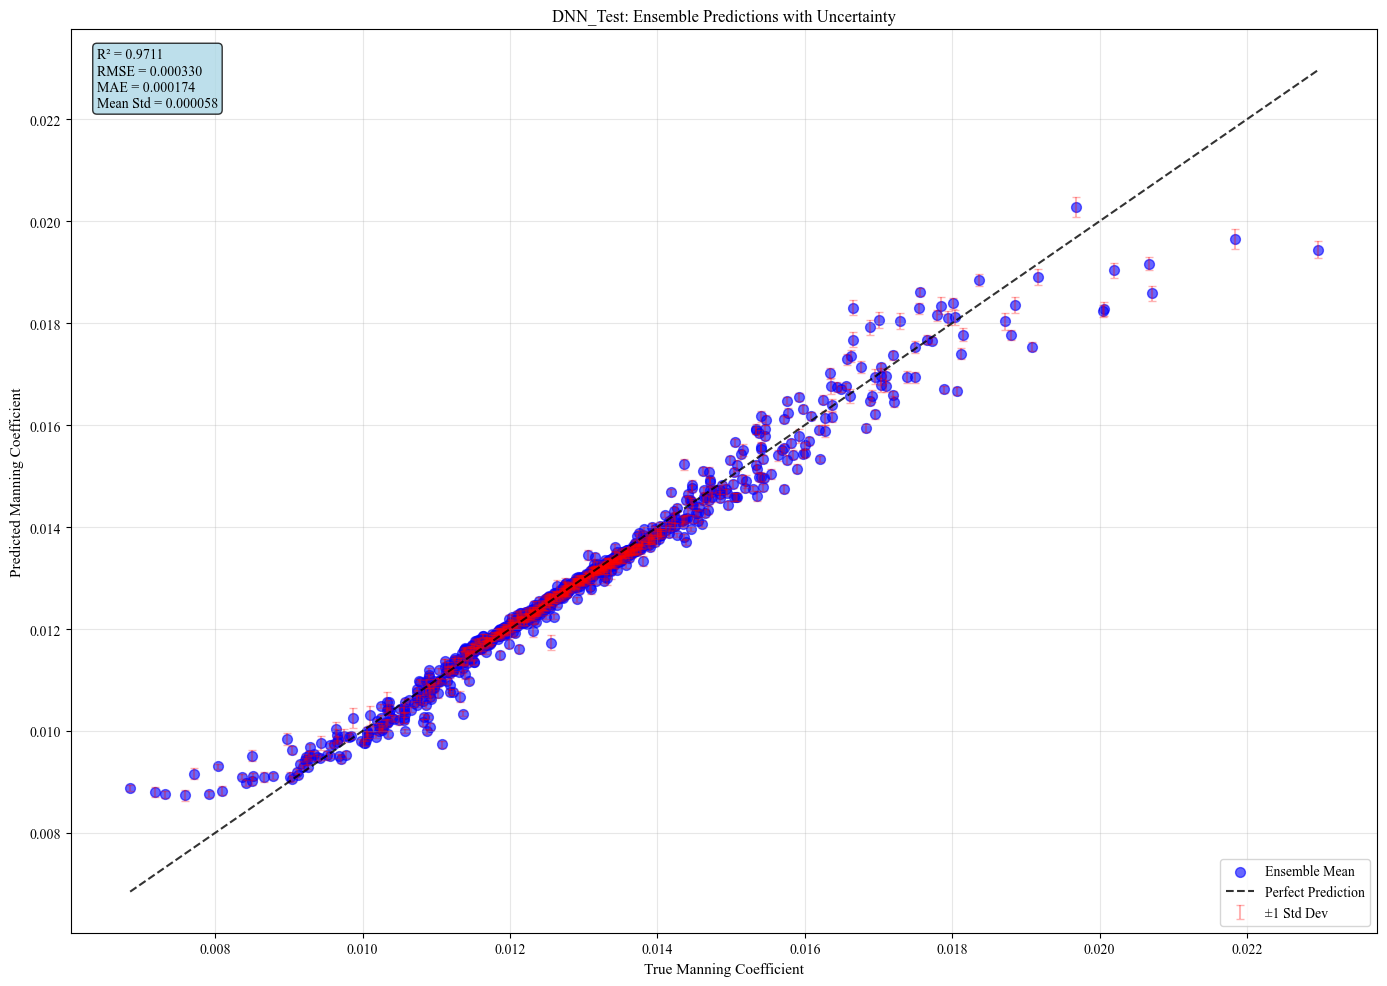

2025-11-21 06:13:13,801 - __main__ - INFO - DNN ensemble predictions plot saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\plots\dnn_train_ensemble_predictions.png


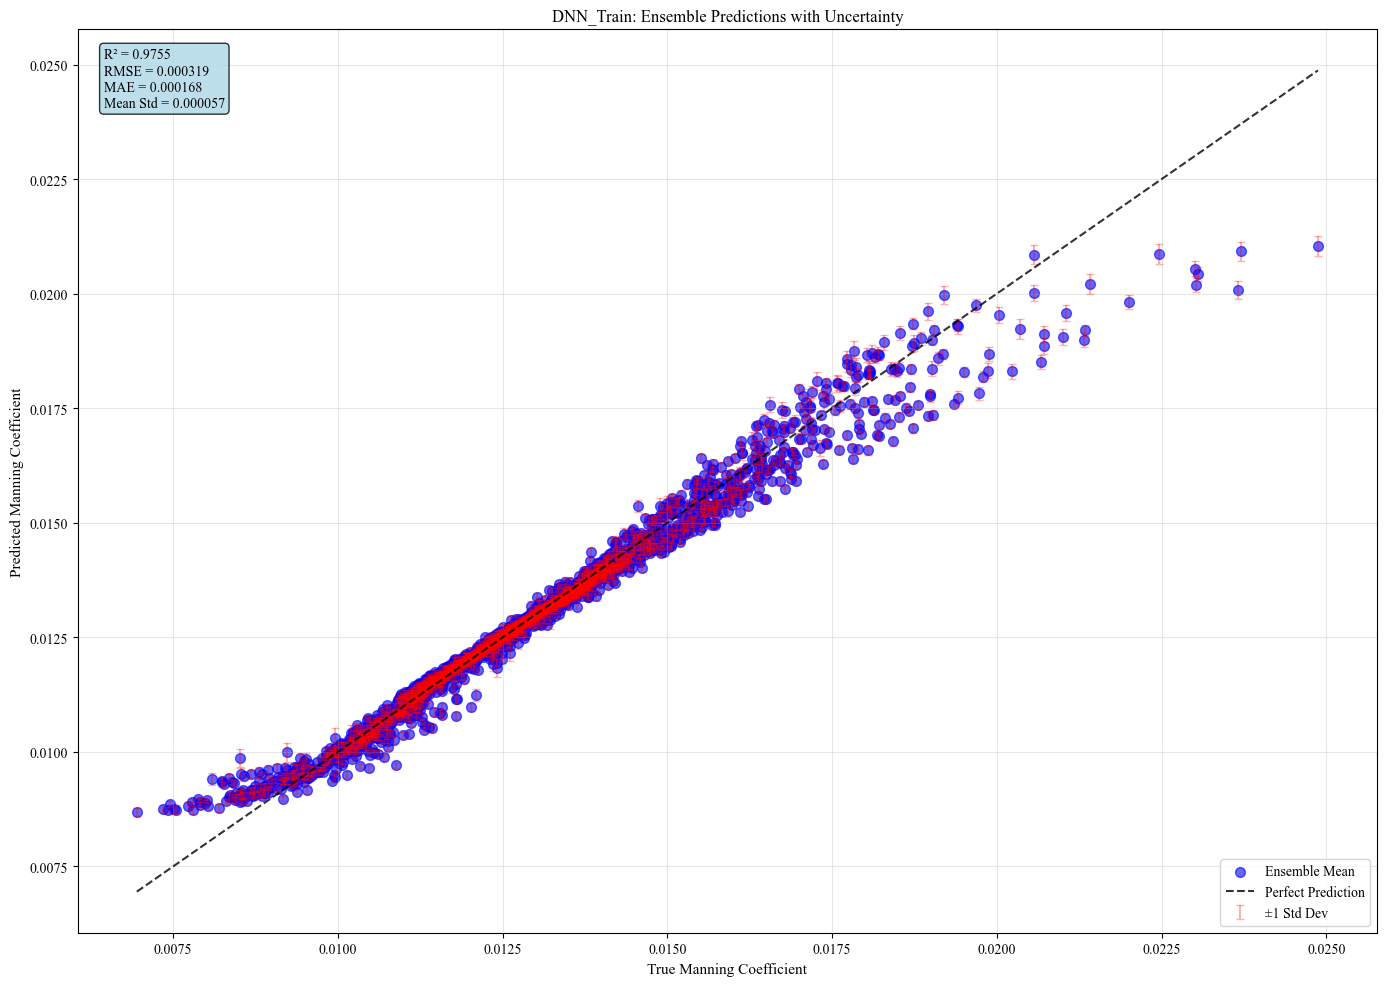

2025-11-21 06:13:14,581 - __main__ - INFO - Evaluating CGAN with Latent Space Sampling (500 samples per condition)...
2025-11-21 06:13:14,591 - __main__ - INFO - Starting latent space sampling with 500 samples per condition...
2025-11-21 08:32:29,645 - __main__ - INFO - Generated predictions shape: (3200, 500, 1, 1)
2025-11-21 08:40:30,697 - __main__ - INFO - Applying physical constraints to CGAN latent sampling predictions...
2025-11-21 08:40:30,712 - __main__ - INFO - Applying physical constraints: n_min=0.0069, n_max=0.0249
2025-11-21 08:40:30,746 - __main__ - INFO - Number of predictions clipped: 0 out of 1600000
2025-11-21 08:40:30,749 - __main__ - INFO - Latent space sampling completed: (3200, 500, 1, 1)
2025-11-21 08:40:30,792 - __main__ - INFO - Starting latent space sampling with 500 samples per condition...
2025-11-21 09:23:58,584 - __main__ - INFO - Generated predictions shape: (1000, 500, 1, 1)
2025-11-21 09:26:45,045 - __main__ - INFO - Applying physical constraints to CGA


MANNING COEFFICIENT PREDICTION - TRADITIONAL METRICS WITH LATENT SAMPLING
              RMSE     MAE     MAPE   rRMSE      R2
DNN_Train   0.0003  0.0002   1.2700  2.4739  0.9755
DNN_Test    0.0003  0.0002   1.3477  2.5619  0.9711
CGAN_Train  0.0006  0.0003  16.6006  4.5754  0.9161
CGAN_Test   0.0005  0.0003  15.9970  4.1351  0.9247


2025-11-21 09:26:55,029 - __main__ - INFO - Uncertainty metrics saved to CSV: IMED-LATENT-SAMPLING_21-11-2025_CODE1\latent_sampling\cgan_train_uncertainty_metrics.csv
2025-11-21 09:26:57,553 - __main__ - INFO - Uncertainty metrics saved to CSV: IMED-LATENT-SAMPLING_21-11-2025_CODE1\latent_sampling\cgan_test_uncertainty_metrics.csv
2025-11-21 09:26:57,553 - __main__ - INFO - Creating uncertainty analysis plots...
2025-11-21 09:27:07,384 - __main__ - INFO - Uncertainty predictions plot saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\uncertainty\cgan_train_uncertainty_predictions.png


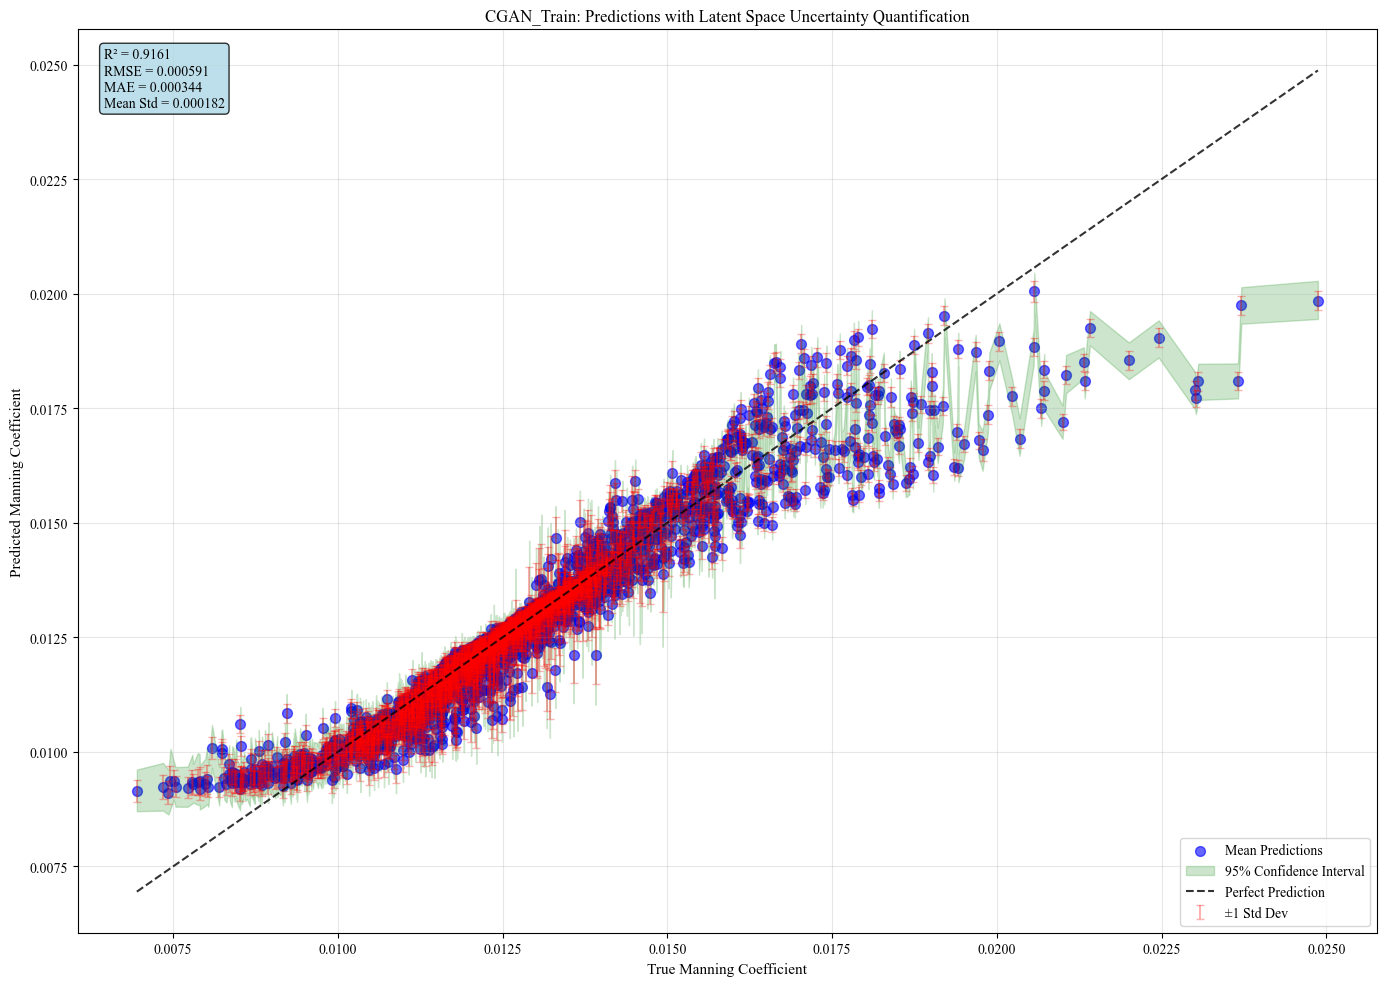

2025-11-21 09:27:11,565 - __main__ - INFO - Uncertainty distribution plot saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\uncertainty\cgan_train_uncertainty_distribution.png


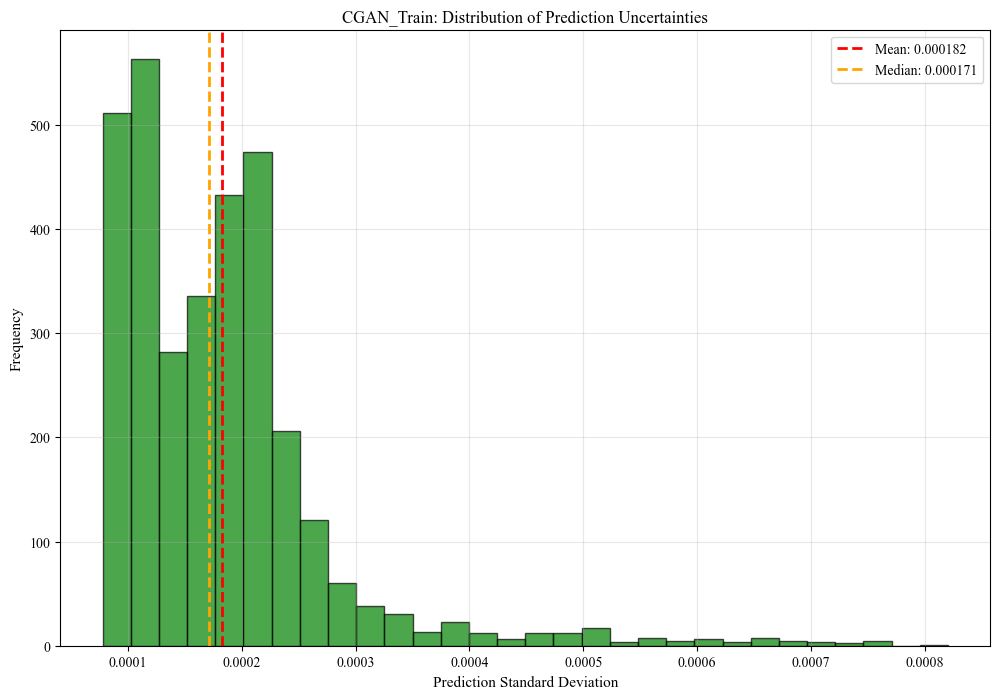

2025-11-21 09:27:16,672 - __main__ - INFO - Coefficient of variation plot saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\uncertainty\cgan_train_coefficient_of_variation.png


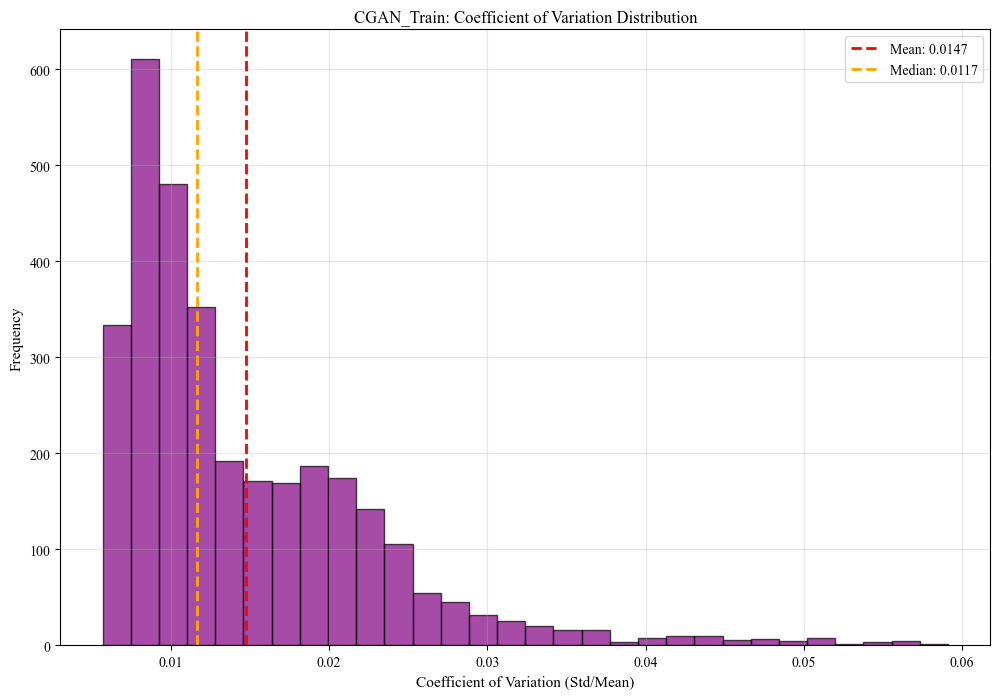

2025-11-21 09:27:19,927 - __main__ - INFO - Prediction intervals plot saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\uncertainty\cgan_train_prediction_intervals.png


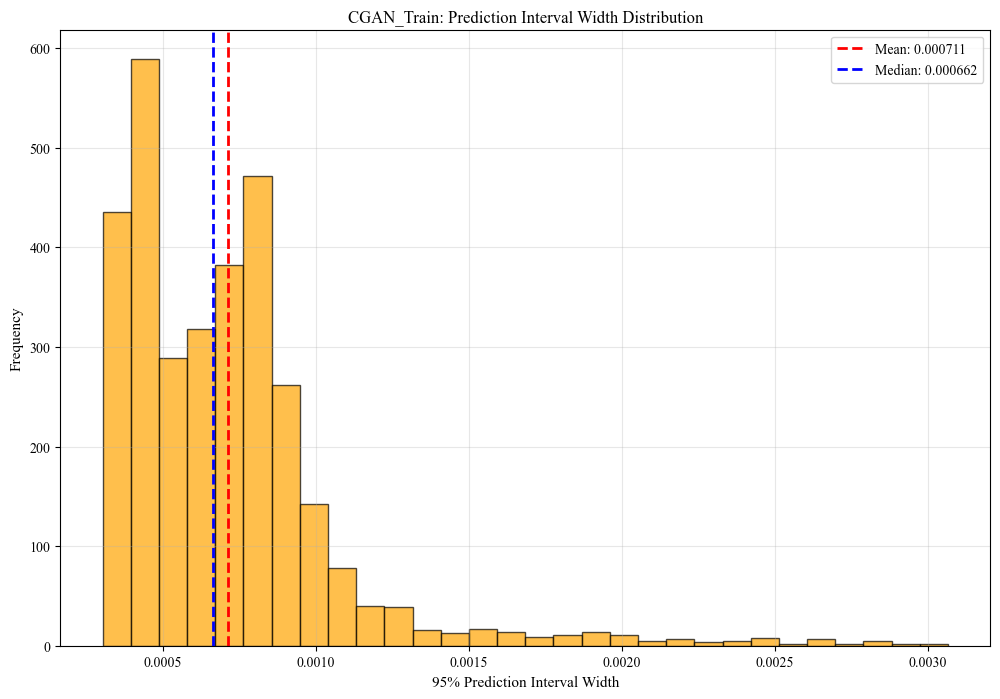

2025-11-21 09:27:27,008 - __main__ - INFO - Uncertainty predictions plot saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\uncertainty\cgan_test_uncertainty_predictions.png


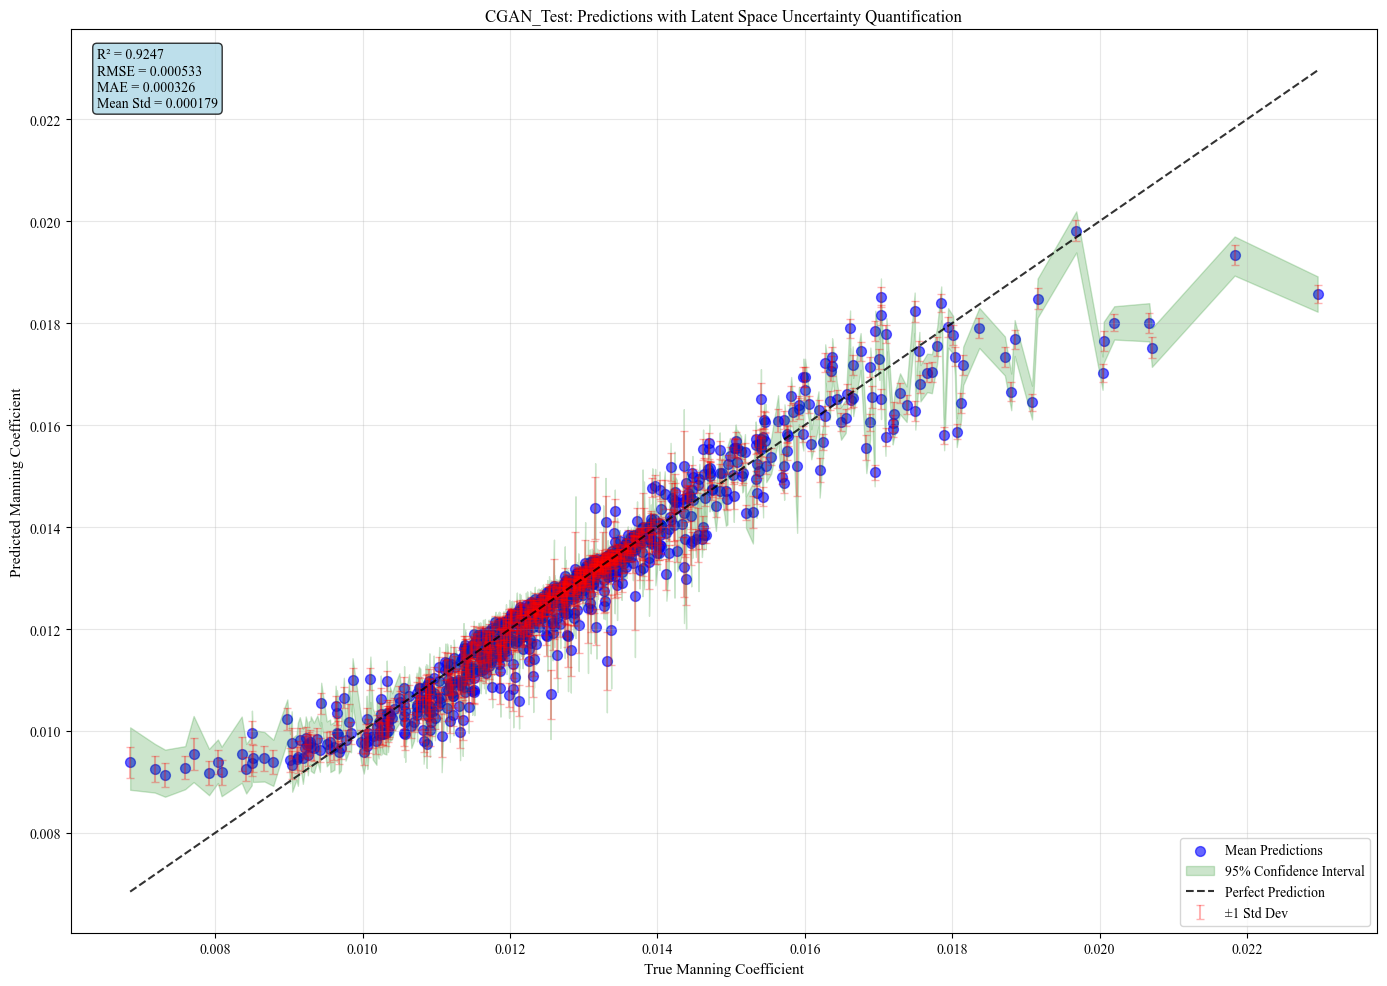

2025-11-21 09:27:30,700 - __main__ - INFO - Uncertainty distribution plot saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\uncertainty\cgan_test_uncertainty_distribution.png


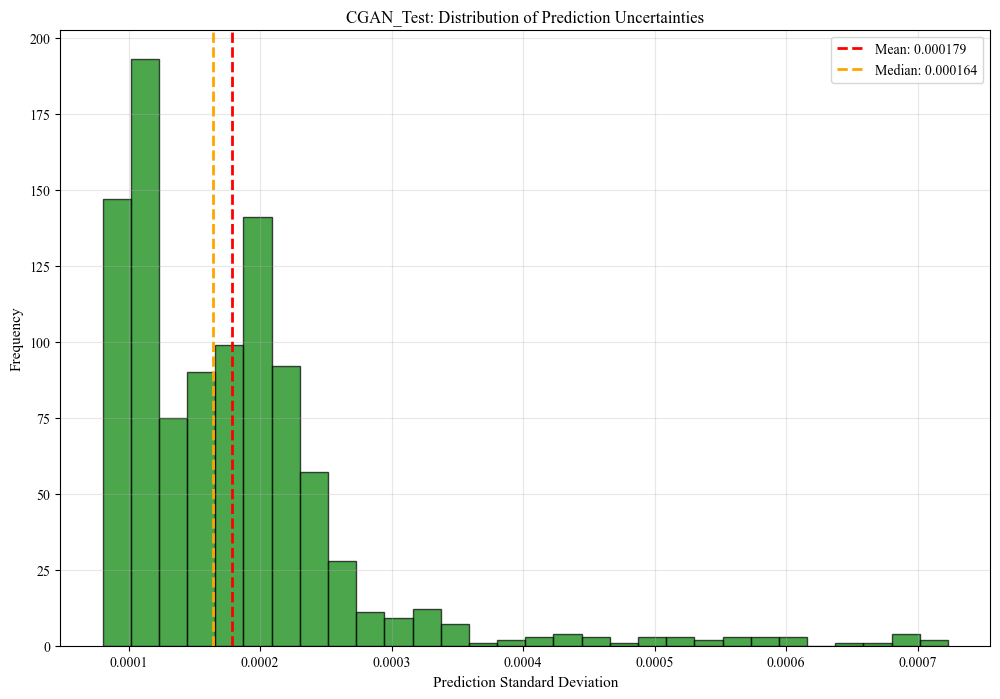

2025-11-21 09:27:33,969 - __main__ - INFO - Coefficient of variation plot saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\uncertainty\cgan_test_coefficient_of_variation.png


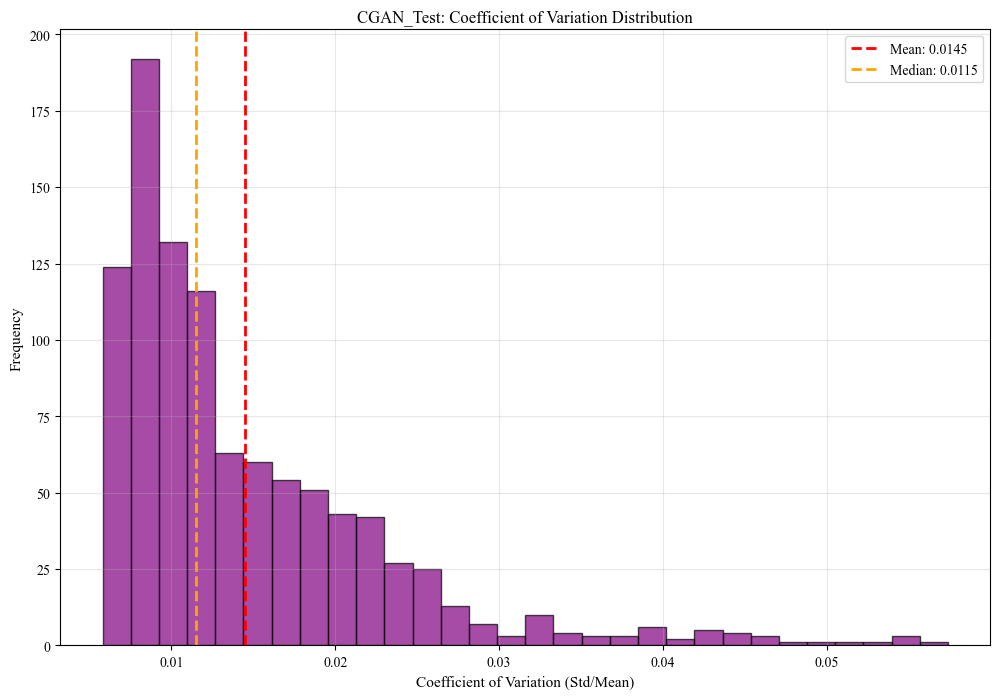

2025-11-21 09:27:37,130 - __main__ - INFO - Prediction intervals plot saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\uncertainty\cgan_test_prediction_intervals.png


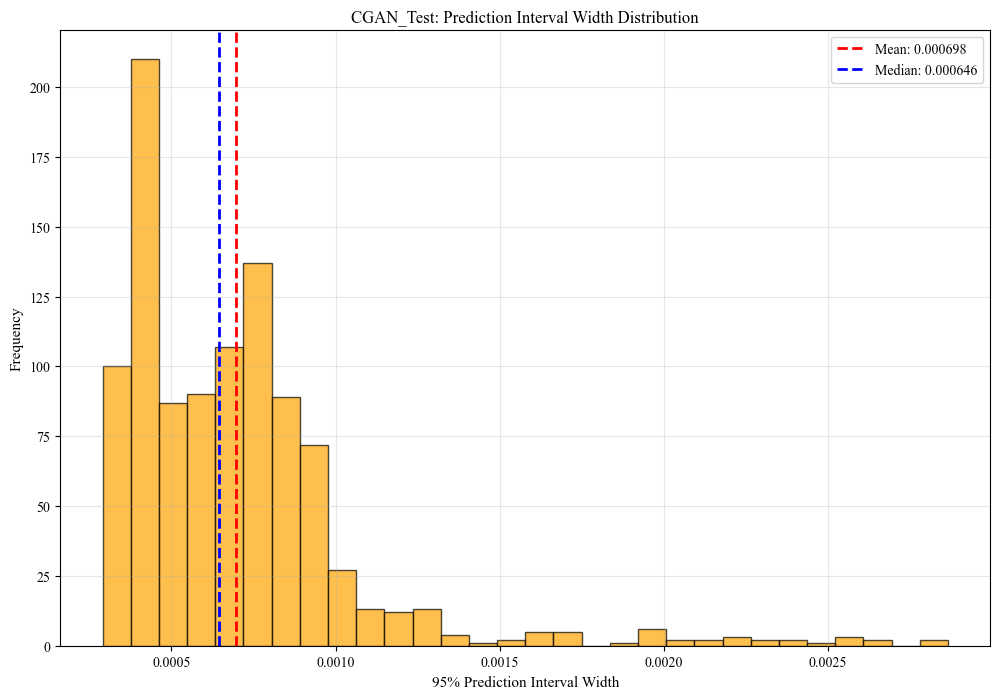

2025-11-21 09:27:37,641 - __main__ - INFO - Creating comprehensive relative error histogram comparison...
2025-11-21 09:27:38,598 - matplotlib.font_manager - WARNING - findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
2025-11-21 09:27:38,646 - matplotlib.font_manager - WARNING - findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
2025-11-21 09:27:38,667 - matplotlib.font_manager - WARNING - findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
2025-11-21 09:27:38,702 - matplotlib.font_manager - WARNING - findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
2025-11-21 09:27:38,707 - matplotlib.font_manager - WARNING - findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
2025-11-21 09:27:38,739 - matplotlib.font_manager - WARNING - findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
2025-11-21 09:27:38,774 - matplotlib.font_manager - WARNING - findfont: Font family ['


COMPLETE TEST DATASET CONVEX HULL ANALYSIS WITH UNCERTAINTY - DNN
Training data size: 3200 points (used to create convex hull)
Test data size: 1000 points (ALL analyzed)
Points inside hull: 996 (99.6%)
Points outside hull: 4 (0.4%)
PCA explained variance: 0.415
Overall mean uncertainty: 0.000000


2025-11-21 09:27:51,584 - __main__ - INFO - Convex hull with uncertainty visualization saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\plots\dnn_convex_hull_with_uncertainty.png


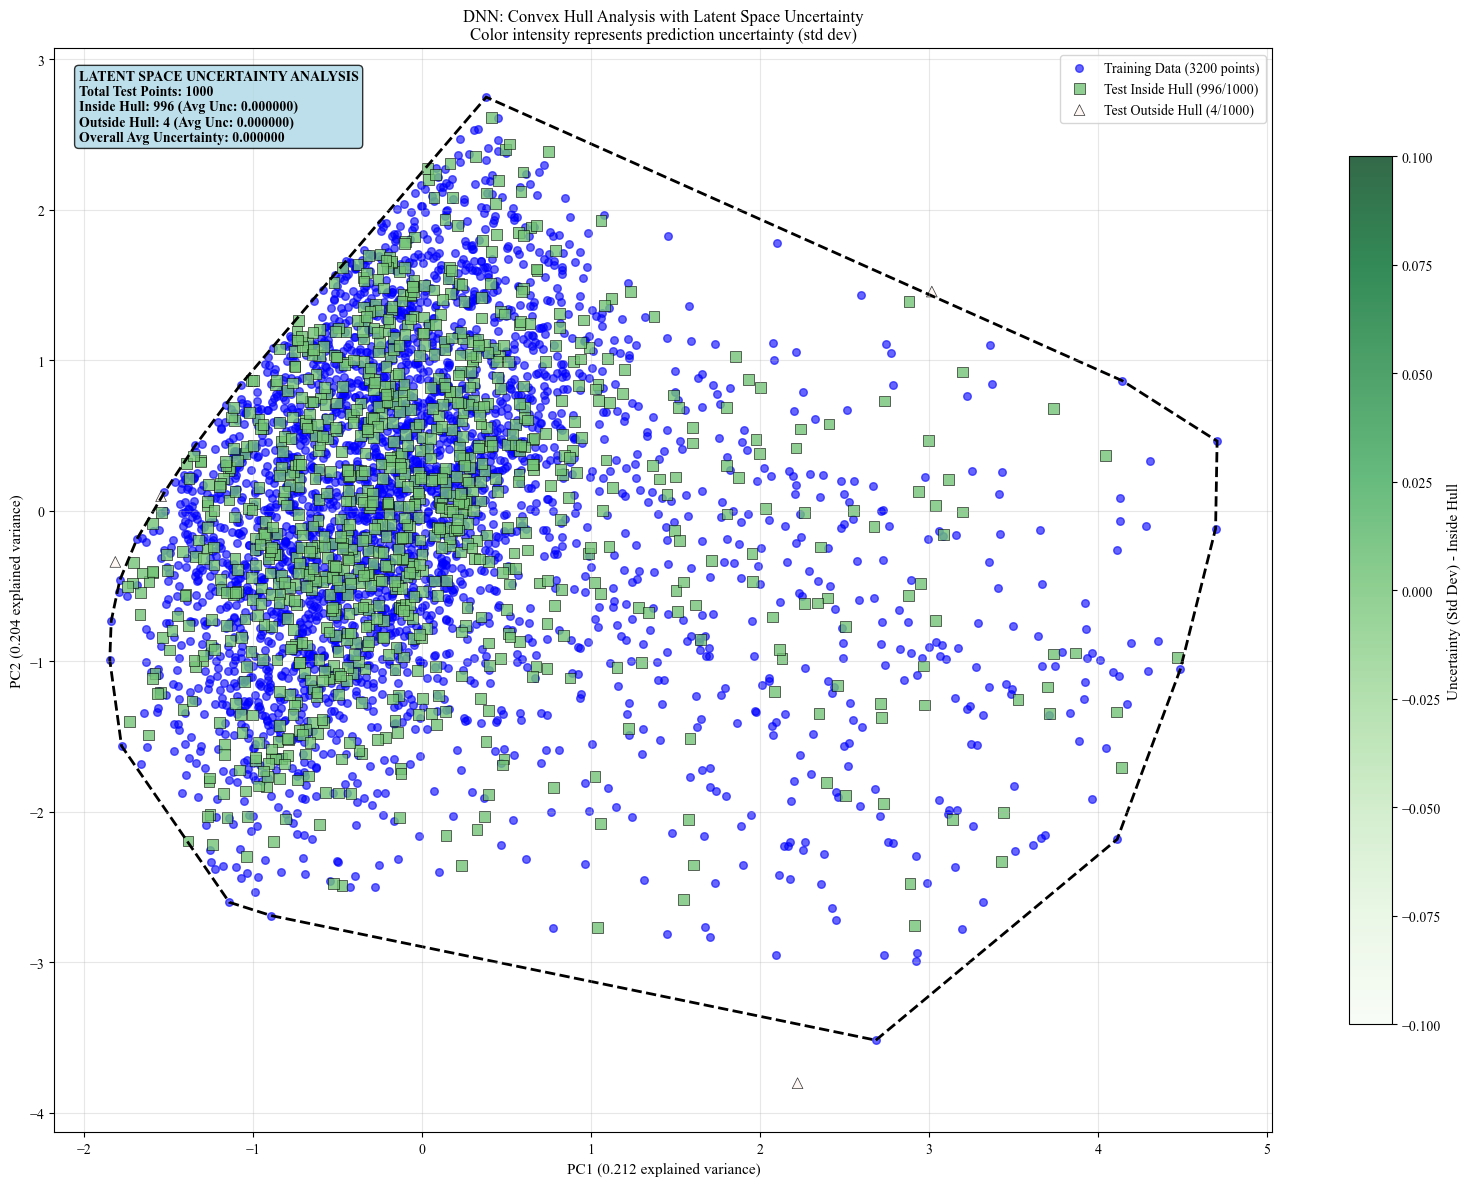

2025-11-21 09:27:52,833 - __main__ - INFO - Complete test dataset convex hull with uncertainty statistics saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\convex_hull_analysis\dnn_complete_test_convex_hull_uncertainty_stats.csv
2025-11-21 09:27:52,833 - __main__ - INFO - Performing Enhanced PCA Convex Hull Analysis with Uncertainty for CGAN_with_Latent_Sampling...
2025-11-21 09:27:52,833 - __main__ - INFO - Using COMPLETE test dataset: 1000 points for convex hull analysis
2025-11-21 09:27:52,833 - __main__ - INFO - Training dataset size: 3200 points (used to create convex hull)
2025-11-21 09:27:52,849 - __main__ - INFO - PCA transformation completed: explained variance ratio: [0.21168962 0.20357326]
2025-11-21 09:27:52,849 - __main__ - INFO - Convex hull created with 18 vertices from training data
2025-11-21 09:27:52,865 - __main__ - INFO - Complete test dataset analysis results: Total=1000, Inside=996, Outside=4
2025-11-21 09:27:52,883 - __main__ - INFO - Creating enhanced plots with unce


COMPLETE TEST DATASET CONVEX HULL ANALYSIS WITH UNCERTAINTY - CGAN_with_Latent_Sampling
Training data size: 3200 points (used to create convex hull)
Test data size: 1000 points (ALL analyzed)
Points inside hull: 996 (99.6%)
Points outside hull: 4 (0.4%)
PCA explained variance: 0.415
Overall mean uncertainty: 0.000179


2025-11-21 09:28:01,614 - __main__ - INFO - Convex hull with uncertainty visualization saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\plots\cgan_with_latent_sampling_convex_hull_with_uncertainty.png


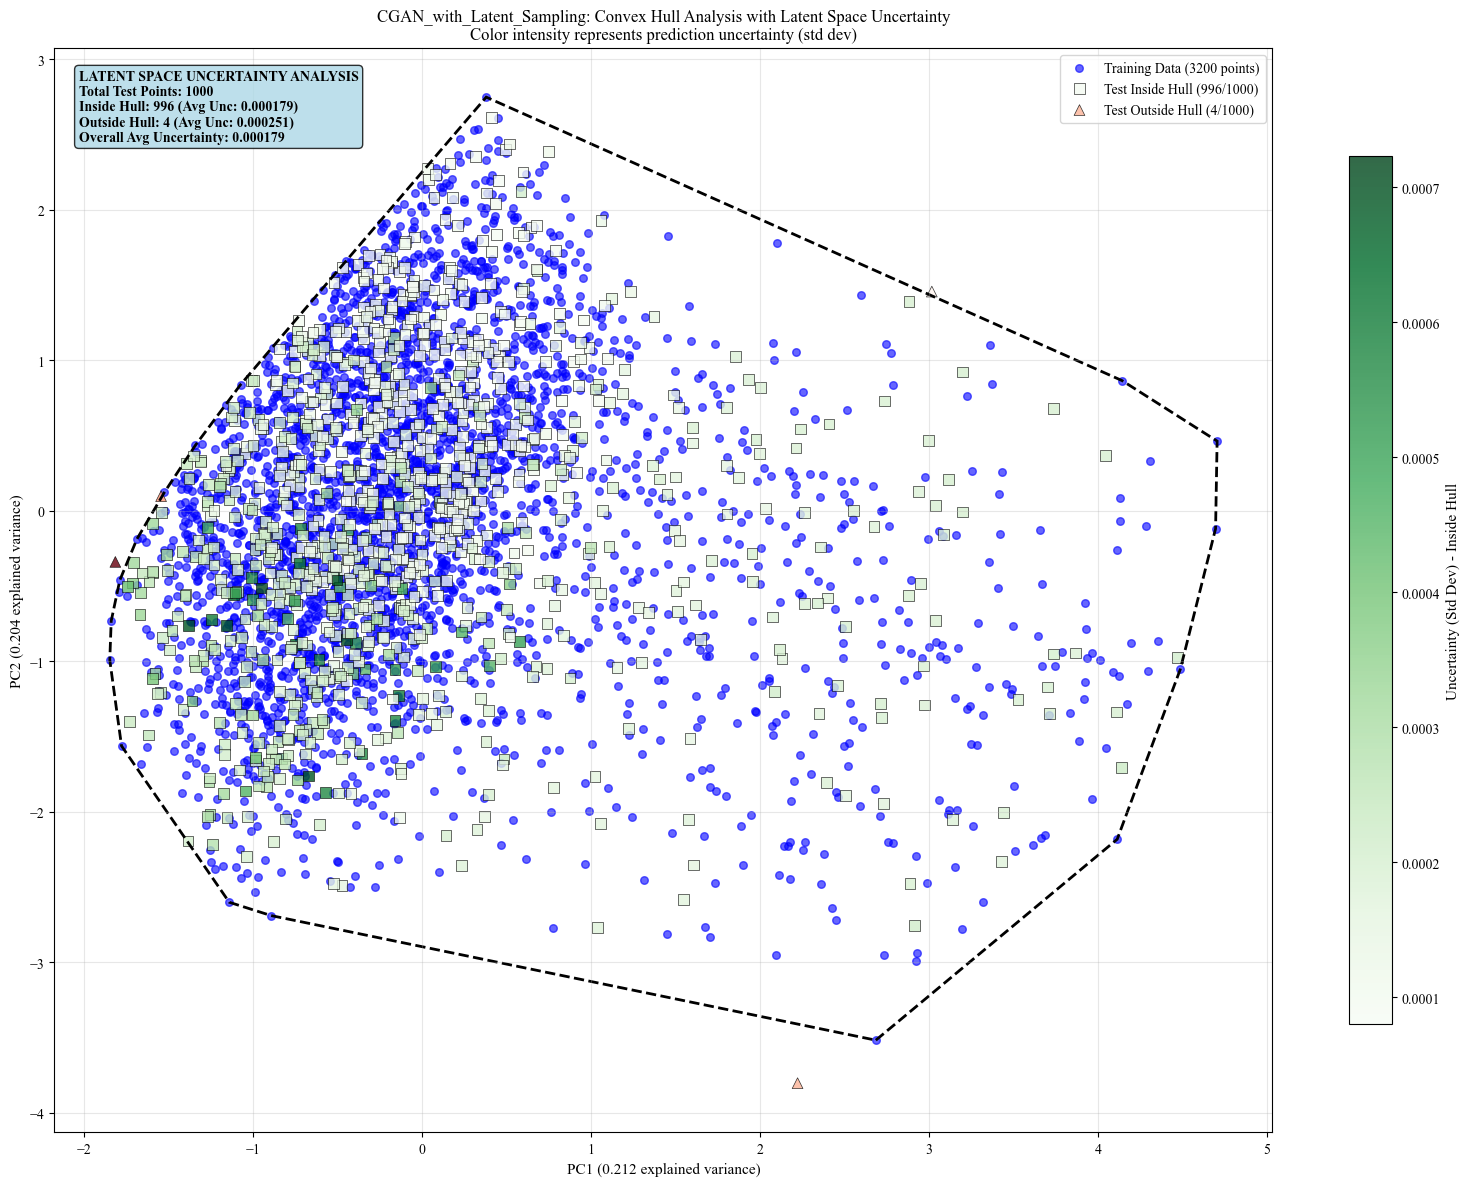

2025-11-21 09:28:02,497 - __main__ - INFO - Complete test dataset convex hull with uncertainty statistics saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\convex_hull_analysis\cgan_with_latent_sampling_complete_test_convex_hull_uncertainty_stats.csv
2025-11-21 09:28:02,586 - __main__ - INFO - Comprehensive convex hull with latent sampling results saved to CSV
2025-11-21 09:28:02,594 - __main__ - INFO - Comprehensive latent sampling analysis report saved: IMED-LATENT-SAMPLING_21-11-2025_CODE1\comprehensive_report\latent_sampling_analysis_report.txt
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\envs\MLDL_2025\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\ASUS\anaconda3\envs\MLDL_2025\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2705' in position 44: character maps 


ENHANCED CONVEX HULL ANALYSIS WITH LATENT SPACE UNCERTAINTY
ALL TEST POINTS ANALYZED WITH UNCERTAINTY QUANTIFICATION
                      train_mean_rel_error  train_std_rel_error  \
DNN_Traditional                     1.2700               1.9433   
CGAN_Latent_Sampling                2.6042               3.2812   

                      train_max_rel_error  train_fraction_above_5pct  \
DNN_Traditional                   25.1680                     0.0438   
CGAN_Latent_Sampling              31.6877                     0.1422   

                      train_r2  test_inside_mean_rel_error  \
DNN_Traditional         0.9755                      1.3381   
CGAN_Latent_Sampling    0.9161                      2.5478   

                      test_inside_std_rel_error  test_inside_max_rel_error  \
DNN_Traditional                          2.2559                    29.7139   
CGAN_Latent_Sampling                     3.3249                    37.0059   

                      test_inside_fractio

2025-11-21 09:28:02,692 - __main__ - INFO - Starting LIME analysis for DNN_Explainability...
2025-11-21 09:28:02,711 - __main__ - ERROR - LIME analysis failed: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import yaml
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from datetime import datetime
import warnings
from matplotlib import gridspec
from matplotlib.patches import Polygon
import shap
import lime
import lime.lime_tabular
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torchvision import transforms
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, accuracy_score
import json
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set global font and style
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 11
rcParams['axes.labelsize'] = 11
rcParams['axes.titlesize'] = 12
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Times New Roman'
rcParams['mathtext.it'] = 'Times New Roman:italic'
rcParams['mathtext.bf'] = 'Times New Roman:bold'
rcParams['axes.grid'] = False

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('imed_mdpi_framework.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# ============================================================================
# DIRECTORY MANAGEMENT
# ============================================================================

def ensure_dir(directory):
    """Create directory if it doesn't exist"""
    if not os.path.exists(directory):
        os.makedirs(directory)
        logger.info(f"Created directory: {directory}")

def setup_save_directories(base_dir="IMED-MDPI"):
    """Setup all necessary directories for saving results"""
    directories = [
        base_dir,
        os.path.join(base_dir, "plots"),
        os.path.join(base_dir, "data"),
        os.path.join(base_dir, "metrics"),
        os.path.join(base_dir, "predictions"),
        os.path.join(base_dir, "models"),
        os.path.join(base_dir, "domain_analysis"),
        os.path.join(base_dir, "uncertainty"),
        os.path.join(base_dir, "feature_analysis"),
        os.path.join(base_dir, "optimization"),
        os.path.join(base_dir, "convex_hull_analysis"),
        os.path.join(base_dir, "comprehensive_report"),
        os.path.join(base_dir, "config"),
        os.path.join(base_dir, "raw_data"),
        os.path.join(base_dir, "training_history"),
        os.path.join(base_dir, "ensemble_results"),
        os.path.join(base_dir, "latent_sampling"),
        os.path.join(base_dir, "explainability"),
        os.path.join(base_dir, "generation_metrics")
    ]
    for directory in directories:
        ensure_dir(directory)
    return base_dir

# ============================================================================
# COMPREHENSIVE DATA SAVING FUNCTIONS
# ============================================================================

def save_configuration_to_csv(config, save_dir):
    """Save configuration parameters to CSV"""
    config_data = []
    for key, value in config.items():
        config_data.append({
            'Parameter': key,
            'Value': str(value),
            'Type': type(value).__name__
        })
    config_df = pd.DataFrame(config_data)
    filepath = os.path.join(save_dir, "config", "model_configuration.csv")
    config_df.to_csv(filepath, index=False)
    logger.info(f"Configuration saved to CSV: {filepath}")
    return filepath

def save_raw_dataset_info(X, y, feature_names, save_dir):
    """Save raw dataset information to CSV"""
    dataset_info = {
        'Dataset_Info': [
            'Total_Samples',
            'Number_of_Features',
            'Target_Variable',
            'Feature_Names',
            'Target_Mean',
            'Target_Std',
            'Target_Min',
            'Target_Max'
        ],
        'Value': [
            X.shape[0],
            X.shape[1],
            'Manning_Coefficient_n',
            ', '.join(feature_names),
            np.mean(y),
            np.std(y),
            np.min(y),
            np.max(y)
        ]
    }
    info_df = pd.DataFrame(dataset_info)
    filepath = os.path.join(save_dir, "raw_data", "dataset_info.csv")
    info_df.to_csv(filepath, index=False)
    logger.info(f"Dataset info saved to CSV: {filepath}")
    return filepath

def save_data_splits_to_csv(X_train, X_val, X_test, y_train, y_val, y_test, feature_names, save_dir):
    """Save all data splits to individual CSV files"""
    datasets = {
        'train': (X_train, y_train),
        'validation': (X_val, y_val),
        'test': (X_test, y_test)
    }
    saved_files = []
    for split_name, (X, y) in datasets.items():
        if isinstance(X, torch.Tensor):
            X_np = X.cpu().numpy()
        else:
            X_np = X
        if isinstance(y, torch.Tensor):
            y_np = y.cpu().numpy()
        else:
            y_np = y
        df = pd.DataFrame(X_np, columns=feature_names)
        df['Manning_Coefficient_n'] = y_np.flatten()
        df['Data_Split'] = split_name
        df['Sample_Index'] = range(len(df))
        filepath = os.path.join(save_dir, "raw_data", f"{split_name}_data.csv")
        df.to_csv(filepath, index=False)
        saved_files.append(filepath)
        logger.info(f"{split_name.capitalize()} data saved to CSV: {filepath}")
    return saved_files

# ============================================================================
# DNN MODEL SAVING FUNCTIONS
# ============================================================================

def save_dnn_predictions_to_csv(y_true, predictions_array, model_name, save_dir):
    """Save DNN ensemble predictions to CSV"""
    mean_predictions = np.mean(predictions_array, axis=0).flatten()
    std_predictions = np.std(predictions_array, axis=0).flatten()
    dnn_data = []
    for i in range(len(y_true)):
        row = {
            'Sample_Index': i,
            'True_Manning_Coefficient': y_true[i][0] if y_true[i].ndim > 0 else y_true[i],
            'Mean_Prediction': mean_predictions[i],
            'Std_Prediction': std_predictions[i],
            'Relative_Error_Percent': abs((y_true.flatten()[i] - mean_predictions[i]) / y_true.flatten()[i]) * 100
        }
        for j in range(predictions_array.shape[0]):
            row[f'Model_{j+1}_Prediction'] = predictions_array[j][i][0] if predictions_array[j][i].ndim > 0 else predictions_array[j][i]
        dnn_data.append(row)
    df = pd.DataFrame(dnn_data)
    filepath = os.path.join(save_dir, "predictions", f"{model_name.lower()}_detailed_predictions.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"DNN detailed predictions saved to CSV: {filepath}")
    return filepath

def save_dnn_ensemble_statistics_to_csv(y_true, predictions_array, model_name, save_dir):
    """Save DNN ensemble statistics similar to CGAN uncertainty metrics"""
    mean_predictions = np.mean(predictions_array, axis=0)
    std_predictions = np.std(predictions_array, axis=0)
    percentile_2_5 = np.percentile(predictions_array, 2.5, axis=0)
    percentile_97_5 = np.percentile(predictions_array, 97.5, axis=0)
    percentile_25 = np.percentile(predictions_array, 25, axis=0)
    percentile_75 = np.percentile(predictions_array, 75, axis=0)
    median_predictions = np.median(predictions_array, axis=0)
    ensemble_data = []
    for i in range(len(y_true)):
        row = {
            'Sample_Index': i,
            'Mean_Prediction': mean_predictions[i][0] if mean_predictions[i].ndim > 0 else mean_predictions[i],
            'Std_Prediction': std_predictions[i][0] if std_predictions[i].ndim > 0 else std_predictions[i],
            'Coefficient_of_Variation': (std_predictions[i] / (abs(mean_predictions[i]) + 1e-8))[0] if mean_predictions[i].ndim > 0 else (std_predictions[i] / (abs(mean_predictions[i]) + 1e-8)),
            'CI_Lower_2_5': percentile_2_5[i][0] if percentile_2_5[i].ndim > 0 else percentile_2_5[i],
            'CI_Upper_97_5': percentile_97_5[i][0] if percentile_97_5[i].ndim > 0 else percentile_97_5[i],
            'Prediction_Interval': (percentile_97_5[i] - percentile_2_5[i])[0] if percentile_97_5[i].ndim > 0 else (percentile_97_5[i] - percentile_2_5[i]),
            'Median_Prediction': median_predictions[i][0] if median_predictions[i].ndim > 0 else median_predictions[i],
            'Percentile_25': percentile_25[i][0] if percentile_25[i].ndim > 0 else percentile_25[i],
            'Percentile_75': percentile_75[i][0] if percentile_75[i].ndim > 0 else percentile_75[i],
        }
        ensemble_data.append(row)
    df = pd.DataFrame(ensemble_data)
    filepath = os.path.join(save_dir, "ensemble_results", f"{model_name.lower()}_ensemble_statistics.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"DNN ensemble statistics saved to CSV: {filepath}")
    return filepath

def save_dnn_training_history_to_csv(histories, save_dir):
    """Save DNN training history to CSV"""
    all_history_data = []
    for model_idx, history in enumerate(histories):
        for epoch, (train_loss, val_loss) in enumerate(zip(history['train_losses'], history['val_losses'])):
            all_history_data.append({
                'Model_Index': model_idx + 1,
                'Epoch': epoch + 1,
                'Training_Loss': train_loss,
                'Validation_Loss': val_loss
            })
    df = pd.DataFrame(all_history_data)
    filepath = os.path.join(save_dir, "training_history", "dnn_ensemble_training_history.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"DNN training history saved to CSV: {filepath}")
    return filepath

def save_trained_models(dnn_models, cgan_generator, cgan_discriminator, save_dir):
    """Save trained model state dictionaries"""
    models_dir = os.path.join(save_dir, "models")
    ensure_dir(models_dir)
    for i, model in enumerate(dnn_models):
        torch.save(model.state_dict(), os.path.join(models_dir, f"dnn_model_{i+1}.pth"))
    torch.save(cgan_generator.state_dict(), os.path.join(models_dir, "cgan_generator.pth"))
    torch.save(cgan_discriminator.state_dict(), os.path.join(models_dir, "cgan_discriminator.pth"))
    logger.info(f"All trained models saved to: {models_dir}")

# ============================================================================
# LOSS FUNCTION VISUALIZATION FUNCTIONS
# ============================================================================

def plot_dnn_ensemble_training_losses(histories, save_dir):
    """Plot training and validation losses for all DNN models in ensemble"""
    plots_dir = os.path.join(save_dir, "plots")
    training_history_dir = os.path.join(save_dir, "training_history")
    ensure_dir(plots_dir)
    ensure_dir(training_history_dir)
    
    n_models = len(histories)
    
    # Plot 1: Individual model losses in subplots
    fig, axes = plt.subplots(2, (n_models + 1) // 2, figsize=(20, 10))
    axes = axes.flatten() if n_models > 1 else [axes]
    
    for idx, history in enumerate(histories):
        ax = axes[idx]
        epochs = range(1, len(history['train_losses']) + 1)
        
        ax.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=1.5)
        ax.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=1.5)
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Loss (MSE)', fontsize=10)
        ax.set_title(f'DNN Model {idx+1}', fontsize=11)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplots if odd number of models
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('DNN Ensemble: Training and Validation Losses', fontsize=14, fontweight='bold')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, "dnn_ensemble_individual_losses.jpg")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"DNN individual losses plot saved: {filepath}")
    plt.close()
    
    # Plot 2: Average ensemble losses with confidence bands
    fig, ax = plt.subplots(figsize=(14, 8))
    
    max_epochs = max([len(h['train_losses']) for h in histories])
    train_losses_all = np.zeros((n_models, max_epochs))
    val_losses_all = np.zeros((n_models, max_epochs))
    
    # Pad shorter histories with NaN
    for idx, history in enumerate(histories):
        n_epochs = len(history['train_losses'])
        train_losses_all[idx, :n_epochs] = history['train_losses']
        val_losses_all[idx, :n_epochs] = history['val_losses']
        train_losses_all[idx, n_epochs:] = np.nan
        val_losses_all[idx, n_epochs:] = np.nan
    
    # Calculate mean and std (ignoring NaNs)
    train_mean = np.nanmean(train_losses_all, axis=0)
    train_std = np.nanstd(train_losses_all, axis=0)
    val_mean = np.nanmean(val_losses_all, axis=0)
    val_std = np.nanstd(val_losses_all, axis=0)
    
    epochs = range(1, max_epochs + 1)
    
    # Plot mean lines
    ax.plot(epochs, train_mean, 'b-', label='Mean Training Loss', linewidth=2)
    ax.plot(epochs, val_mean, 'r-', label='Mean Validation Loss', linewidth=2)
    
    # Plot confidence bands (±1 std)
    ax.fill_between(epochs, train_mean - train_std, train_mean + train_std, 
                     alpha=0.2, color='blue', label='Training ±1 Std')
    ax.fill_between(epochs, val_mean - val_std, val_mean + val_std, 
                     alpha=0.2, color='red', label='Validation ±1 Std')
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss (MSE)', fontsize=11)
    ax.set_title('DNN Ensemble: Average Training and Validation Losses', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add statistics text box
    final_train_mean = train_mean[~np.isnan(train_mean)][-1]
    final_val_mean = val_mean[~np.isnan(val_mean)][-1]
    stats_text = f'Final Training Loss: {final_train_mean:.6f}\nFinal Validation Loss: {final_val_mean:.6f}\nEnsemble Size: {n_models}'
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    filepath = os.path.join(plots_dir, "dnn_ensemble_average_losses.jpg")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"DNN average ensemble losses plot saved: {filepath}")
    plt.close()
    
    # Plot 3: All models overlaid (semi-transparent)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    for idx, history in enumerate(histories):
        epochs = range(1, len(history['train_losses']) + 1)
        ax1.plot(epochs, history['train_losses'], alpha=0.4, linewidth=1)
        ax2.plot(epochs, history['val_losses'], alpha=0.4, linewidth=1)
    
    ax1.plot(range(1, len(train_mean) + 1), train_mean, 'k-', linewidth=2.5, label='Ensemble Mean')
    ax2.plot(range(1, len(val_mean) + 1), val_mean, 'k-', linewidth=2.5, label='Ensemble Mean')
    
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Training Loss (MSE)', fontsize=11)
    ax1.set_title('All DNN Models: Training Losses', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('Validation Loss (MSE)', fontsize=11)
    ax2.set_title('All DNN Models: Validation Losses', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    filepath = os.path.join(plots_dir, "dnn_ensemble_all_models_losses.jpg")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"DNN all models losses plot saved: {filepath}")
    plt.close()

def plot_cgan_training_losses(history, save_dir):
    """Plot training losses for CGAN (Generator, Discriminator, and Validation)"""
    plots_dir = os.path.join(save_dir, "plots")
    training_history_dir = os.path.join(save_dir, "training_history")
    ensure_dir(plots_dir)
    ensure_dir(training_history_dir)
    
    epochs = range(1, len(history['losses_G']) + 1)
    
    # Plot 1: Generator and Discriminator losses
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.plot(epochs, history['losses_G'], 'g-', label='Generator Loss', linewidth=2, alpha=0.8)
    ax.plot(epochs, history['losses_D'], 'b-', label='Discriminator Loss', linewidth=2, alpha=0.8)
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss (BCE)', fontsize=11)
    ax.set_title('CGAN: Generator and Discriminator Training Losses', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    final_g_loss = history['losses_G'][-1]
    final_d_loss = history['losses_D'][-1]
    stats_text = f'Final Generator Loss: {final_g_loss:.6f}\nFinal Discriminator Loss: {final_d_loss:.6f}\nTotal Epochs: {len(epochs)}'
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    filepath = os.path.join(plots_dir, "cgan_generator_discriminator_losses.jpg")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"CGAN G/D losses plot saved: {filepath}")
    plt.close()
    
    # Plot 2: Validation loss
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.plot(epochs, history['val_losses'], 'r-', label='Validation Loss (MSE)', linewidth=2)
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Validation Loss (MSE)', fontsize=11)
    ax.set_title('CGAN Generator: Validation Loss', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    final_val_loss = history['val_losses'][-1]
    min_val_loss = min(history['val_losses'])
    min_val_epoch = history['val_losses'].index(min_val_loss) + 1
    stats_text = f'Final Validation Loss: {final_val_loss:.6f}\nBest Validation Loss: {min_val_loss:.6f}\nBest Epoch: {min_val_epoch}'
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # Mark best validation loss
    ax.axvline(min_val_epoch, color='green', linestyle='--', alpha=0.5, label=f'Best Val Loss (Epoch {min_val_epoch})')
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    filepath = os.path.join(plots_dir, "cgan_validation_loss.jpg")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"CGAN validation loss plot saved: {filepath}")
    plt.close()
    
    # Plot 3: Combined comprehensive view
    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    
    # Generator and Discriminator losses
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(epochs, history['losses_G'], 'g-', label='Generator Loss', linewidth=2, alpha=0.8)
    ax1.plot(epochs, history['losses_D'], 'b-', label='Discriminator Loss', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Loss (BCE)', fontsize=11)
    ax1.set_title('Generator and Discriminator Losses', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Validation loss
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(epochs, history['val_losses'], 'r-', linewidth=2)
    ax2.axvline(min_val_epoch, color='green', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('Validation Loss (MSE)', fontsize=11)
    ax2.set_title('Validation Loss', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Loss ratio (G/D)
    ax3 = fig.add_subplot(gs[1, 1])
    loss_ratio = np.array(history['losses_G']) / (np.array(history['losses_D']) + 1e-8)
    ax3.plot(epochs, loss_ratio, 'purple', linewidth=2)
    ax3.axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Ideal Ratio = 1')
    ax3.set_xlabel('Epoch', fontsize=11)
    ax3.set_ylabel('Loss Ratio (G/D)', fontsize=11)
    ax3.set_title('Generator to Discriminator Loss Ratio', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle('CGAN: Comprehensive Training Loss Analysis', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    filepath = os.path.join(plots_dir, "cgan_comprehensive_losses.jpg")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"CGAN comprehensive losses plot saved: {filepath}")
    plt.close()
    
    # Save loss history to CSV
    loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Generator_Loss': history['losses_G'],
        'Discriminator_Loss': history['losses_D'],
        'Validation_Loss': history['val_losses'],
        'Loss_Ratio_G_D': loss_ratio
    })
    filepath_csv = os.path.join(training_history_dir, "cgan_training_losses.csv")
    loss_df.to_csv(filepath_csv, index=False)
    logger.info(f"CGAN training losses saved to CSV: {filepath_csv}")

def plot_dnn_vs_cgan_comparison(dnn_histories, cgan_history, save_dir):
    """Plot comparison of DNN and CGAN training convergence"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # DNN average validation loss
    max_epochs_dnn = max([len(h['val_losses']) for h in dnn_histories])
    val_losses_all = np.zeros((len(dnn_histories), max_epochs_dnn))
    
    for idx, history in enumerate(dnn_histories):
        n_epochs = len(history['val_losses'])
        val_losses_all[idx, :n_epochs] = history['val_losses']
        val_losses_all[idx, n_epochs:] = np.nan
    
    dnn_val_mean = np.nanmean(val_losses_all, axis=0)
    dnn_epochs = range(1, max_epochs_dnn + 1)
    
    # CGAN validation loss
    cgan_epochs = range(1, len(cgan_history['val_losses']) + 1)
    
    # Plot 1: Validation losses comparison
    ax1.plot(dnn_epochs, dnn_val_mean, 'b-', label='DNN Ensemble (Mean)', linewidth=2)
    ax1.plot(cgan_epochs, cgan_history['val_losses'], 'r-', label='CGAN Generator', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Validation Loss (MSE)', fontsize=11)
    ax1.set_title('DNN vs CGAN: Validation Loss Comparison', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Normalized losses (0-1 scale)
    dnn_val_norm = (dnn_val_mean - np.nanmin(dnn_val_mean)) / (np.nanmax(dnn_val_mean) - np.nanmin(dnn_val_mean) + 1e-8)
    cgan_val_norm = (np.array(cgan_history['val_losses']) - min(cgan_history['val_losses'])) / (max(cgan_history['val_losses']) - min(cgan_history['val_losses']) + 1e-8)
    
    ax2.plot(dnn_epochs, dnn_val_norm, 'b-', label='DNN Ensemble (Normalized)', linewidth=2)
    ax2.plot(cgan_epochs, cgan_val_norm, 'r-', label='CGAN Generator (Normalized)', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('Normalized Validation Loss', fontsize=11)
    ax2.set_title('Normalized Convergence Comparison', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    filepath = os.path.join(plots_dir, "dnn_vs_cgan_loss_comparison.jpg")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"DNN vs CGAN comparison plot saved: {filepath}")
    plt.close()

# ============================================================================
# RELATIVE ERROR ANALYSIS FUNCTIONS
# ============================================================================

def plot_relative_error_histograms_comparison(y_true_dnn, y_pred_dnn, y_true_cgan, y_pred_cgan, save_dir):
    """Plot relative error histograms for DNN and CGAN"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    dnn_rel_error = np.abs((y_true_dnn.flatten() - y_pred_dnn.flatten()) / y_true_dnn.flatten()) * 100
    cgan_rel_error = np.abs((y_true_cgan.flatten() - y_pred_cgan.flatten()) / y_true_cgan.flatten()) * 100
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    # DNN Relative Error Histogram
    ax1.hist(dnn_rel_error, bins=30, alpha=0.7, color='blue', edgecolor='black', density=True)
    ax1.axvline(np.mean(dnn_rel_error), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(dnn_rel_error):.2f}%')
    ax1.axvline(np.median(dnn_rel_error), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(dnn_rel_error):.2f}%')
    ax1.axvline(5.0, color='green', linestyle=':', linewidth=2, alpha=0.8, label='5% Threshold')
    ax1.set_xlabel(r'Relative Error, $\mathit{E_r}$ (%)', fontsize=11)
    ax1.set_ylabel('Density', fontsize=11)
    ax1.set_title('DNN Ensemble: Relative Error Distribution', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(False)
    # CGAN Relative Error Histogram
    ax2.hist(cgan_rel_error, bins=30, alpha=0.7, color='red', edgecolor='black', density=True)
    ax2.axvline(np.mean(cgan_rel_error), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {np.mean(cgan_rel_error):.2f}%')
    ax2.axvline(np.median(cgan_rel_error), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(cgan_rel_error):.2f}%')
    ax2.axvline(5.0, color='green', linestyle=':', linewidth=2, alpha=0.8, label='5% Threshold')
    ax2.set_xlabel(r'Relative Error, $\mathit{E_r}$ (%)', fontsize=11)
    ax2.set_ylabel('Density', fontsize=11)
    ax2.set_title('CGAN with Latent Sampling: Relative Error Distribution', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(False)
    # Save as JPEG (600 DPI)
    filepath = os.path.join(plots_dir, "comprehensive_relative_error_comparison.jpg")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"Comprehensive relative error comparison saved: {filepath}")

def save_relative_error_statistics_to_csv(dnn_rel_error, cgan_rel_error, save_dir):
    """Save detailed relative error statistics to CSV"""
    stats_data = {
        'Metric': [
            'Mean_Relative_Error_%', 'Median_Relative_Error_%', 'Std_Relative_Error_%',
            'Min_Relative_Error_%', 'Max_Relative_Error_%', 'Q1_Relative_Error_%',
            'Q3_Relative_Error_%', 'Fraction_Above_5_%', 'Fraction_Above_10_%',
            'Fraction_Above_20_%', '95th_Percentile_%', '99th_Percentile_%'
        ],
        'DNN_Ensemble': [
            np.mean(dnn_rel_error), np.median(dnn_rel_error), np.std(dnn_rel_error),
            np.min(dnn_rel_error), np.max(dnn_rel_error), np.percentile(dnn_rel_error, 25),
            np.percentile(dnn_rel_error, 75), np.sum(dnn_rel_error > 5.0) / len(dnn_rel_error),
            np.sum(dnn_rel_error > 10.0) / len(dnn_rel_error), np.sum(dnn_rel_error > 20.0) / len(dnn_rel_error),
            np.percentile(dnn_rel_error, 95), np.percentile(dnn_rel_error, 99)
        ],
        'CGAN_Latent_Sampling': [
            np.mean(cgan_rel_error), np.median(cgan_rel_error), np.std(cgan_rel_error),
            np.min(cgan_rel_error), np.max(cgan_rel_error), np.percentile(cgan_rel_error, 25),
            np.percentile(cgan_rel_error, 75), np.sum(cgan_rel_error > 5.0) / len(cgan_rel_error),
            np.sum(cgan_rel_error > 10.0) / len(cgan_rel_error), np.sum(cgan_rel_error > 20.0) / len(cgan_rel_error),
            np.percentile(cgan_rel_error, 95), np.percentile(cgan_rel_error, 99)
        ]
    }
    df = pd.DataFrame(stats_data)
    filepath = os.path.join(save_dir, "metrics", "relative_error_comprehensive_statistics.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"Relative error statistics saved to CSV: {filepath}")
    return filepath

# ============================================================================
# DNN VISUALIZATION FUNCTIONS
# ============================================================================

def plot_dnn_ensemble_analysis(y_true, predictions_array, model_name, save_dir):
    """Create comprehensive DNN ensemble analysis plots"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    mean_pred = np.mean(predictions_array, axis=0).flatten()
    std_pred = np.std(predictions_array, axis=0).flatten()
    plt.figure(figsize=(14, 10))
    plt.scatter(y_true.flatten(), mean_pred, alpha=0.6, c='blue', s=50, label='Ensemble Mean')
    plt.errorbar(y_true.flatten(), mean_pred, yerr=std_pred, fmt='none', alpha=0.3, color='red', capsize=3, label='±1 Std Dev')
    min_val = min(np.min(y_true), np.min(mean_pred))
    max_val = max(np.max(y_true), np.max(mean_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')
    plt.xlabel('True Manning Coefficient')
    plt.ylabel('Predicted Manning Coefficient')
    plt.title(f'{model_name}: Ensemble Predictions with Uncertainty')
    plt.legend()
    plt.grid(True, alpha=0.3)
    r2 = r2_score(y_true.flatten(), mean_pred)
    rmse_val = rmse(y_true.flatten(), mean_pred)
    mae_val = mae(y_true.flatten(), mean_pred)
    stats_text = f'R² = {r2:.4f}\nRMSE = {rmse_val:.6f}\nMAE = {mae_val:.6f}\nMean Std = {np.mean(std_pred):.6f}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_ensemble_predictions.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"DNN ensemble predictions plot saved: {filepath}")
    plt.show()

def plot_shap_waterfall(shap_values, test_data, feature_names, sample_idx, save_dir, model_name):
    """Plot SHAP Waterfall Plot for a specific sample"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.plots.waterfall(shap.Explanation(values=shap_values[sample_idx],
                                         base_values=shap_values[sample_idx].sum(),
                                         data=test_data[sample_idx],
                                         feature_names=feature_names))
    plt.title(f'{model_name}: SHAP Waterfall Plot - Sample {sample_idx}')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_waterfall_sample_{sample_idx}.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Waterfall Plot for sample {sample_idx} saved: {filepath}")

def plot_shap_force(shap_values, test_data, feature_names, sample_idx, save_dir, model_name):
    """Plot SHAP Force Plot for a specific sample"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.force_plot(shap.Explanation(values=shap_values[sample_idx],
                                     base_values=shap_values[sample_idx].sum(),
                                     data=test_data[sample_idx],
                                     feature_names=feature_names),
                    matplotlib=True)
    plt.title(f'{model_name}: SHAP Force Plot - Sample {sample_idx}')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_force_sample_{sample_idx}.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Force Plot for sample {sample_idx} saved: {filepath}")

def plot_shap_summary(shap_values, test_data, feature_names, save_dir, model_name):
    """Plot SHAP Summary Plot"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.summary_plot(shap_values, test_data, feature_names=feature_names, show=False)
    plt.title(f'{model_name}: SHAP Summary Plot')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_summary_plot.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Summary Plot saved: {filepath}")

def plot_shap_dependence(shap_values, test_data, feature_names, feature_idx, save_dir, model_name):
    """Plot SHAP Dependence Plot for a specific feature"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.dependence_plot(feature_idx, shap_values, test_data, feature_names=feature_names, show=False)
    plt.title(f'{model_name}: SHAP Dependence Plot - {feature_names[feature_idx]}')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_dependence_{feature_names[feature_idx]}.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Dependence Plot for {feature_names[feature_idx]} saved: {filepath}")

def plot_shap_bar(shap_values, feature_names, save_dir, model_name):
    """Plot SHAP Bar Plot for feature importance"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.plots.bar(shap.Explanation(values=np.mean(np.abs(shap_values), axis=0),
                                    base_values=0,
                                    data=None,
                                    feature_names=feature_names))
    plt.title(f'{model_name}: SHAP Feature Importance (Bar Plot)')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_bar_plot.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Bar Plot saved: {filepath}")

def plot_shap_heatmap(shap_values, feature_names, save_dir, model_name):
    """Plot SHAP Heatmap for all samples"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.plots.heatmap(shap.Explanation(values=shap_values,
                                        base_values=np.zeros(shap_values.shape[1]),
                                        data=None,
                                        feature_names=feature_names))
    plt.title(f'{model_name}: SHAP Heatmap')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_heatmap.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Heatmap saved: {filepath}")

def plot_shap_feature_summary(shap_values, test_data, feature_names, save_dir, model_name):
    """Plot SHAP Feature Summary for global feature importance"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.summary_plot(shap_values, test_data, feature_names=feature_names, show=False)
    plt.title(f'{model_name}: SHAP Feature Summary')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_feature_summary.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Feature Summary Plot saved: {filepath}")

def plot_shap_feature_importance(shap_values, feature_names, save_dir, model_name):
    """Plot SHAP Feature Importance Bar Plot for global feature importance"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure()
    shap.summary_plot(shap_values, features=feature_names, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f'{model_name}: SHAP Feature Importance')
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_shap_feature_importance.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"SHAP Feature Importance Plot saved: {filepath}")

def plot_lime_explanation(lime_explanation, sample_idx, feature_names, save_dir, model_name):
    """Plot LIME Explanation for a specific sample"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    fig = lime_explanation.as_pyplot_figure()
    fig.suptitle(f'{model_name}: LIME Explanation - Sample {sample_idx}', fontsize=14)
    lime_filepath = os.path.join(plots_dir, f"{model_name.lower()}_lime_explanation_sample_{sample_idx}.png")
    fig.savefig(lime_filepath, dpi=600, bbox_inches='tight')
    plt.close()
    logger.info(f"LIME Explanation for sample {sample_idx} saved: {lime_filepath}")

# ============================================================================
# METRICS FUNCTIONS
# ============================================================================

def rmse(y_true, y_pred):
    """Root Mean Square Error"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    """Mean Absolute Error"""
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rrmse(y_true, y_pred):
    """Relative Root Mean Square Error"""
    return rmse(y_true, y_pred) / np.mean(y_true) * 100

def calculate_metrics(y_true, y_pred):
    """Calculate all metrics"""
    return {
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'MAPE': mape(y_true, y_pred),
        'rRMSE': rrmse(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# ============================================================================
# PHYSICAL CONSTRAINTS FOR CGAN PREDICTIONS
# ============================================================================

def apply_physical_constraints(predictions, y_true):
    """Apply physical constraints to CGAN predictions by clipping them to the range [min(y_true), max(y_true)]"""
    n_min = np.min(y_true)
    n_max = np.max(y_true)
    logger.info(f"Applying physical constraints: n_min={n_min:.4f}, n_max={n_max:.4f}")
    if predictions.ndim == 1:
        clipped_predictions = np.clip(predictions, n_min, n_max)
    elif predictions.ndim == 2:
        clipped_predictions = np.clip(predictions, n_min, n_max)
    elif predictions.ndim == 3:
        clipped_predictions = np.clip(predictions, n_min, n_max)
    else:
        clipped_predictions = np.clip(predictions, n_min, n_max)
    n_clipped = np.sum((predictions < n_min) | (predictions > n_max))
    logger.info(f"Number of predictions clipped: {n_clipped} out of {predictions.size}")
    return clipped_predictions

# ============================================================================
# LATENT SPACE SAMPLING FUNCTIONS
# ============================================================================

def evaluate_cgan_with_latent_sampling(generator, X_data, y_data, scaler_y, n_samples=500):
    """Evaluate CGAN using latent space sampling for uncertainty quantification"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_data, y_data = X_data.to(device), y_data.to(device)
    logger.info(f"Starting latent space sampling with {n_samples} samples per condition...")
    generator.eval()
    all_predictions = []
    with torch.no_grad():
        for i in range(X_data.shape[0]):
            condition = X_data[i:i+1]
            sample_predictions = []
            for _ in range(n_samples):
                pred = generator(condition)
                sample_predictions.append(pred.cpu().numpy())
            all_predictions.append(np.array(sample_predictions))
    predictions_array = np.array(all_predictions)
    logger.info(f"Generated predictions shape: {predictions_array.shape}")
    y_true = scaler_y.inverse_transform(y_data.cpu().numpy())
    predictions_scaled = np.zeros_like(predictions_array)
    for i in range(predictions_array.shape[0]):
        for j in range(predictions_array.shape[1]):
            predictions_scaled[i, j] = scaler_y.inverse_transform(predictions_array[i, j])
    logger.info("Applying physical constraints to CGAN latent sampling predictions...")
    predictions_scaled = apply_physical_constraints(predictions_scaled, y_true)
    logger.info(f"Latent space sampling completed: {predictions_scaled.shape}")
    return y_true, predictions_scaled

def analyze_ensemble_statistics(predictions_array):
    """Analyze statistical properties of ensemble predictions"""
    logger.info(f"Analyzing ensemble statistics for predictions shape: {predictions_array.shape}")
    mean_predictions = np.mean(predictions_array, axis=1)
    std_predictions = np.std(predictions_array, axis=1)
    percentile_2_5 = np.percentile(predictions_array, 2.5, axis=1)
    percentile_97_5 = np.percentile(predictions_array, 97.5, axis=1)
    coefficient_of_variation = std_predictions / (np.abs(mean_predictions) + 1e-8)
    prediction_intervals = percentile_97_5 - percentile_2_5
    median_predictions = np.median(predictions_array, axis=1)
    percentile_25 = np.percentile(predictions_array, 25, axis=1)
    percentile_75 = np.percentile(predictions_array, 75, axis=1)
    uncertainty_metrics = {
        'mean_predictions': mean_predictions,
        'std_predictions': std_predictions,
        'coefficient_of_variation': coefficient_of_variation,
        'confidence_interval_lower': percentile_2_5,
        'confidence_interval_upper': percentile_97_5,
        'prediction_intervals': prediction_intervals,
        'median_predictions': median_predictions,
        'percentile_25': percentile_25,
        'percentile_75': percentile_75,
        'raw_predictions': predictions_array
    }
    logger.info("Ensemble statistics analysis completed")
    logger.info(f"Mean std deviation: {np.mean(std_predictions):.6f}")
    logger.info(f"Mean prediction interval: {np.mean(prediction_intervals):.6f}")
    logger.info(f"Mean coefficient of variation: {np.mean(coefficient_of_variation):.6f}")
    return uncertainty_metrics

def save_uncertainty_metrics_to_csv(uncertainty_metrics, model_name, save_dir):
    """Save uncertainty metrics to CSV file"""
    flattened_data = []
    n_samples = len(uncertainty_metrics['mean_predictions'])
    for i in range(n_samples):
        row = {
            'Sample_Index': i,
            'Mean_Prediction': uncertainty_metrics['mean_predictions'][i][0] if uncertainty_metrics['mean_predictions'][i].ndim > 0 else uncertainty_metrics['mean_predictions'][i],
            'Std_Prediction': uncertainty_metrics['std_predictions'][i][0] if uncertainty_metrics['std_predictions'][i].ndim > 0 else uncertainty_metrics['std_predictions'][i],
            'Coefficient_of_Variation': uncertainty_metrics['coefficient_of_variation'][i][0] if uncertainty_metrics['coefficient_of_variation'][i].ndim > 0 else uncertainty_metrics['coefficient_of_variation'][i],
            'CI_Lower_2_5': uncertainty_metrics['confidence_interval_lower'][i][0] if uncertainty_metrics['confidence_interval_lower'][i].ndim > 0 else uncertainty_metrics['confidence_interval_lower'][i],
            'CI_Upper_97_5': uncertainty_metrics['confidence_interval_upper'][i][0] if uncertainty_metrics['confidence_interval_upper'][i].ndim > 0 else uncertainty_metrics['confidence_interval_upper'][i],
            'Prediction_Interval': uncertainty_metrics['prediction_intervals'][i][0] if uncertainty_metrics['prediction_intervals'][i].ndim > 0 else uncertainty_metrics['prediction_intervals'][i],
            'Median_Prediction': uncertainty_metrics['median_predictions'][i][0] if uncertainty_metrics['median_predictions'][i].ndim > 0 else uncertainty_metrics['median_predictions'][i],
            'Percentile_25': uncertainty_metrics['percentile_25'][i][0] if uncertainty_metrics['percentile_25'][i].ndim > 0 else uncertainty_metrics['percentile_25'][i],
            'Percentile_75': uncertainty_metrics['percentile_75'][i][0] if uncertainty_metrics['percentile_75'][i].ndim > 0 else uncertainty_metrics['percentile_75'][i],
        }
        flattened_data.append(row)
    df = pd.DataFrame(flattened_data)
    filepath = os.path.join(save_dir, "latent_sampling", f"{model_name.lower()}_uncertainty_metrics.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"Uncertainty metrics saved to CSV: {filepath}")
    return filepath

# ============================================================================
# UNCERTAINTY VISUALIZATION FUNCTIONS
# ============================================================================

def plot_uncertainty_analysis(y_true, uncertainty_metrics, model_name, save_dir):
    """Plot comprehensive uncertainty analysis including confidence intervals"""
    plots_dir = os.path.join(save_dir, "uncertainty")
    ensure_dir(plots_dir)
    mean_pred = uncertainty_metrics['mean_predictions'].flatten()
    std_pred = uncertainty_metrics['std_predictions'].flatten()
    lower_ci = uncertainty_metrics['confidence_interval_lower'].flatten()
    upper_ci = uncertainty_metrics['confidence_interval_upper'].flatten()
    plt.figure(figsize=(14, 10))
    plt.scatter(y_true.flatten(), mean_pred, alpha=0.6, c='blue', s=50, label='Mean Predictions')
    plt.errorbar(y_true.flatten(), mean_pred, yerr=std_pred, fmt='none', alpha=0.3, color='red', capsize=3, label='±1 Std Dev')
    indices = np.argsort(y_true.flatten())
    y_true_sorted = y_true.flatten()[indices]
    mean_pred_sorted = mean_pred[indices]
    lower_ci_sorted = lower_ci[indices]
    upper_ci_sorted = upper_ci[indices]
    plt.fill_between(y_true_sorted, lower_ci_sorted, upper_ci_sorted, alpha=0.2, color='green', label='95% Confidence Interval')
    min_val = min(np.min(y_true), np.min(mean_pred))
    max_val = max(np.max(y_true), np.max(mean_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')
    plt.xlabel('True Manning Coefficient')
    plt.ylabel('Predicted Manning Coefficient')
    plt.title(f'{model_name}: Predictions with Latent Space Uncertainty Quantification')
    plt.legend()
    plt.grid(True, alpha=0.3)
    r2 = r2_score(y_true.flatten(), mean_pred)
    rmse_val = rmse(y_true.flatten(), mean_pred)
    mae_val = mae(y_true.flatten(), mean_pred)
    stats_text = f'R² = {r2:.4f}\nRMSE = {rmse_val:.6f}\nMAE = {mae_val:.6f}\nMean Std = {np.mean(std_pred):.6f}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.tight_layout()
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_uncertainty_predictions.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"Uncertainty predictions plot saved: {filepath}")
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.hist(std_pred, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(np.mean(std_pred), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(std_pred):.6f}')
    plt.axvline(np.median(std_pred), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(std_pred):.6f}')
    plt.xlabel('Prediction Standard Deviation')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: Distribution of Prediction Uncertainties')
    plt.legend()
    plt.grid(True, alpha=0.3)
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_uncertainty_distribution.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"Uncertainty distribution plot saved: {filepath}")
    plt.show()
    plt.figure(figsize=(12, 8))
    cv = uncertainty_metrics['coefficient_of_variation'].flatten()
    plt.hist(cv, bins=30, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(np.mean(cv), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(cv):.4f}')
    plt.axvline(np.median(cv), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(cv):.4f}')
    plt.xlabel('Coefficient of Variation (Std/Mean)')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: Coefficient of Variation Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_coefficient_of_variation.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"Coefficient of variation plot saved: {filepath}")
    plt.show()
    plt.figure(figsize=(12, 8))
    pred_intervals = uncertainty_metrics['prediction_intervals'].flatten()
    plt.hist(pred_intervals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(np.mean(pred_intervals), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(pred_intervals):.6f}')
    plt.axvline(np.median(pred_intervals), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(pred_intervals):.6f}')
    plt.xlabel('95% Prediction Interval Width')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: Prediction Interval Width Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    filepath = os.path.join(plots_dir, f"{model_name.lower()}_prediction_intervals.png")
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"Prediction intervals plot saved: {filepath}")
    plt.show()

# ============================================================================
# ENHANCED CONVEX HULL FUNCTIONS
# ============================================================================

def points_in_convex_hull_2d(points, hull):
    """Determine which points are inside a 2D convex hull"""
    try:
        A = hull.equations[:, :-1]
        b = hull.equations[:, -1]
        is_inside = np.all(np.dot(points, A.T) + b <= 1e-12, axis=1)
        return is_inside
    except Exception as e:
        logger.warning(f"Convex hull point classification failed: {e}")
        return np.ones(len(points), dtype=bool)

def pca_convex_hull_analysis_with_uncertainty(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, uncertainty_metrics, model_name, save_dir=None):
    """Enhanced uncertainty quantification using PCA and convex hull analysis"""
    logger.info(f"Performing Enhanced PCA Convex Hull Analysis with Uncertainty for {model_name}...")
    X_train = X_train.cpu().numpy() if isinstance(X_train, torch.Tensor) else X_train
    X_test = X_test.cpu().numpy() if isinstance(X_test, torch.Tensor) else X_test
    y_train = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
    y_test = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test
    logger.info(f"Using COMPLETE test dataset: {X_test.shape[0]} points for convex hull analysis")
    logger.info(f"Training dataset size: {X_train.shape[0]} points (used to create convex hull)")
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    logger.info(f"PCA transformation completed: explained variance ratio: {pca.explained_variance_ratio_}")
    try:
        hull = ConvexHull(X_train_pca)
        hull_points = X_train_pca[hull.vertices]
        logger.info(f"Convex hull created with {len(hull.vertices)} vertices from training data")
        inside_hull_test = points_in_convex_hull_2d(X_test_pca, hull)
        outside_hull_test = ~inside_hull_test
        total_test_points = len(inside_hull_test)
        points_inside = np.sum(inside_hull_test)
        points_outside = np.sum(outside_hull_test)
        logger.info(f"Complete test dataset analysis results: Total={total_test_points}, Inside={points_inside}, Outside={points_outside}")
        y_train_flat = y_train_pred.flatten() if y_train_pred.ndim > 1 else y_train_pred
        y_test_flat = y_test_pred.flatten() if y_test_pred.ndim > 1 else y_test_pred
        y_train_true_flat = y_train.flatten()
        y_test_true_flat = y_test.flatten()
        train_rel_error = np.abs((y_train_true_flat - y_train_flat) / y_train_true_flat) * 100
        test_rel_error = np.abs((y_test_true_flat - y_test_flat) / y_test_true_flat) * 100
        test_rel_error_inside = test_rel_error[inside_hull_test]
        test_rel_error_outside = test_rel_error[outside_hull_test]
        y_test_true_inside = y_test_true_flat[inside_hull_test]
        y_test_pred_inside = y_test_flat[inside_hull_test]
        y_test_true_outside = y_test_true_flat[outside_hull_test]
        y_test_pred_outside = y_test_flat[outside_hull_test]
        std_predictions_inside = uncertainty_metrics['std_predictions'].flatten()[inside_hull_test]
        std_predictions_outside = uncertainty_metrics['std_predictions'].flatten()[outside_hull_test]
        cv_inside = uncertainty_metrics['coefficient_of_variation'].flatten()[inside_hull_test]
        cv_outside = uncertainty_metrics['coefficient_of_variation'].flatten()[outside_hull_test]
        def calculate_fraction_above_5pct(rel_errors):
            return np.sum(rel_errors > 5.0) / len(rel_errors) if len(rel_errors) > 0 else np.nan
        def calculate_r2_safe(y_true, y_pred):
            if len(y_true) == 0 or np.var(y_true) == 0:
                return np.nan
            return r2_score(y_true, y_pred)
        def calculate_mean_safe(values):
            return np.mean(values) if len(values) > 0 else np.nan
        stats_results = {
            'train_mean_rel_error': np.mean(train_rel_error),
            'train_std_rel_error': np.std(train_rel_error),
            'train_max_rel_error': np.max(train_rel_error),
            'train_fraction_above_5pct': calculate_fraction_above_5pct(train_rel_error),
            'train_r2': calculate_r2_safe(y_train_true_flat, y_train_flat),
            'test_inside_mean_rel_error': np.mean(test_rel_error_inside) if len(test_rel_error_inside) > 0 else np.nan,
            'test_inside_std_rel_error': np.std(test_rel_error_inside) if len(test_rel_error_inside) > 0 else np.nan,
            'test_inside_max_rel_error': np.max(test_rel_error_inside) if len(test_rel_error_inside) > 0 else np.nan,
            'test_inside_fraction_above_5pct': calculate_fraction_above_5pct(test_rel_error_inside),
            'test_inside_r2': calculate_r2_safe(y_test_true_inside, y_test_pred_inside),
            'test_inside_mean_uncertainty': calculate_mean_safe(std_predictions_inside),
            'test_inside_mean_cv': calculate_mean_safe(cv_inside),
            'test_outside_mean_rel_error': np.mean(test_rel_error_outside) if len(test_rel_error_outside) > 0 else np.nan,
            'test_outside_std_rel_error': np.std(test_rel_error_outside) if len(test_rel_error_outside) > 0 else np.nan,
            'test_outside_max_rel_error': np.max(test_rel_error_outside) if len(test_rel_error_outside) > 0 else np.nan,
            'test_outside_fraction_above_5pct': calculate_fraction_above_5pct(test_rel_error_outside),
            'test_outside_r2': calculate_r2_safe(y_test_true_outside, y_test_pred_outside),
            'test_outside_mean_uncertainty': calculate_mean_safe(std_predictions_outside),
            'test_outside_mean_cv': calculate_mean_safe(cv_outside),
            'test_overall_mean_rel_error': np.mean(test_rel_error),
            'test_overall_std_rel_error': np.std(test_rel_error),
            'test_overall_max_rel_error': np.max(test_rel_error),
            'test_overall_fraction_above_5pct': calculate_fraction_above_5pct(test_rel_error),
            'test_overall_r2': calculate_r2_safe(y_test_true_flat, y_test_flat),
            'test_overall_mean_uncertainty': np.mean(uncertainty_metrics['std_predictions'].flatten()),
            'test_overall_mean_cv': np.mean(uncertainty_metrics['coefficient_of_variation'].flatten()),
            'total_test_points_analyzed': total_test_points,
            'points_inside_hull': points_inside,
            'points_outside_hull': points_outside,
            'inside_hull_ratio': points_inside / total_test_points,
            'outside_hull_ratio': points_outside / total_test_points,
            'pca_explained_variance_1': pca.explained_variance_ratio_[0],
            'pca_explained_variance_2': pca.explained_variance_ratio_[1],
            'total_explained_variance': np.sum(pca.explained_variance_ratio_)
        }
        print("\n" + "="*80)
        print(f"COMPLETE TEST DATASET CONVEX HULL ANALYSIS WITH UNCERTAINTY - {model_name}")
        print("="*80)
        print(f"Training data size: {len(X_train_pca)} points (used to create convex hull)")
        print(f"Test data size: {total_test_points} points (ALL analyzed)")
        print(f"Points inside hull: {points_inside} ({points_inside/total_test_points*100:.1f}%)")
        print(f"Points outside hull: {points_outside} ({points_outside/total_test_points*100:.1f}%)")
        print(f"PCA explained variance: {np.sum(pca.explained_variance_ratio_):.3f}")
        print(f"Overall mean uncertainty: {stats_results['test_overall_mean_uncertainty']:.6f}")
        print("="*80)
        if save_dir:
            logger.info(f"Creating enhanced plots with uncertainty for complete test dataset analysis ({model_name})...")
            plot_enhanced_convex_hull_with_uncertainty(
                X_train_pca, X_test_pca, hull_points, inside_hull_test,
                uncertainty_metrics, model_name, pca, stats_results, save_dir
            )
            save_complete_convex_hull_stats_to_csv(stats_results, model_name, save_dir)
        return (stats_results, pca, hull, inside_hull_test, outside_hull_test,
                train_rel_error, test_rel_error_inside, test_rel_error_outside, uncertainty_metrics)
    except Exception as e:
        logger.error(f"Complete test dataset convex hull analysis failed for {model_name}: {e}")
        return None, None, None, None, None, None, None, None, None

def plot_enhanced_convex_hull_with_uncertainty(X_train_pca, X_test_pca, hull_points, inside_hull_test, uncertainty_metrics, model_name, pca, stats_results, save_dir):
    """Plot enhanced convex hull analysis with uncertainty information"""
    plots_dir = os.path.join(save_dir, "plots")
    ensure_dir(plots_dir)
    plt.figure(figsize=(16, 12))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='blue', alpha=0.6, s=30, label=f'Training Data ({len(X_train_pca)} points)')
    X_test_inside = X_test_pca[inside_hull_test]
    X_test_outside = X_test_pca[~inside_hull_test]
    uncertainty_inside = uncertainty_metrics['std_predictions'].flatten()[inside_hull_test]
    uncertainty_outside = uncertainty_metrics['std_predictions'].flatten()[~inside_hull_test]
    total_test_points = len(X_test_pca)
    points_inside = len(X_test_inside)
    points_outside = len(X_test_outside)
    if len(X_test_inside) > 0:
        scatter_inside = plt.scatter(X_test_inside[:, 0], X_test_inside[:, 1], c=uncertainty_inside, cmap='Greens', s=60, marker='s', alpha=0.8, edgecolors='black', linewidth=0.5, label=f'Test Inside Hull ({points_inside}/{total_test_points})')
        plt.colorbar(scatter_inside, label='Uncertainty (Std Dev) - Inside Hull', shrink=0.8)
    if len(X_test_outside) > 0:
        scatter_outside = plt.scatter(X_test_outside[:, 0], X_test_outside[:, 1], c=uncertainty_outside, cmap='Reds', s=60, marker='^', alpha=0.8, edgecolors='black', linewidth=0.5, label=f'Test Outside Hull ({points_outside}/{total_test_points})')
        if len(X_test_inside) == 0:
            plt.colorbar(scatter_outside, label='Uncertainty (Std Dev) - Outside Hull', shrink=0.8)
    hull_polygon = Polygon(hull_points, fill=False, edgecolor='black', linewidth=2, linestyle='--')
    plt.gca().add_patch(hull_polygon)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} explained variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} explained variance)')
    plt.title(f'{model_name}: Convex Hull Analysis with Latent Space Uncertainty\nColor intensity represents prediction uncertainty (std dev)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    textstr = f'LATENT SPACE UNCERTAINTY ANALYSIS\nTotal Test Points: {total_test_points}\nInside Hull: {points_inside} (Avg Unc: {stats_results.get("test_inside_mean_uncertainty", 0):.6f})\nOutside Hull: {points_outside} (Avg Unc: {stats_results.get("test_outside_mean_uncertainty", 0):.6f})\nOverall Avg Uncertainty: {stats_results["test_overall_mean_uncertainty"]:.6f}'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props, fontweight='bold')
    plt.tight_layout()
    filename = f"{model_name.lower()}_convex_hull_with_uncertainty.png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    logger.info(f"Convex hull with uncertainty visualization saved: {filepath}")
    plt.show()

def save_complete_convex_hull_stats_to_csv(stats_results, model_name, save_dir):
    """Save complete convex hull statistics with emphasis on full test dataset usage"""
    df = pd.DataFrame([stats_results])
    df.insert(0, 'Model', model_name)
    df.insert(1, 'Analysis_Type', 'Complete_Test_Dataset_Convex_Hull_With_Uncertainty')
    df.insert(2, 'Test_Points_Coverage', 'All_Test_Data_Used_With_Latent_Sampling')
    filepath = os.path.join(save_dir, "convex_hull_analysis", f"{model_name.lower()}_complete_test_convex_hull_uncertainty_stats.csv")
    df.to_csv(filepath, index=False)
    logger.info(f"Complete test dataset convex hull with uncertainty statistics saved: {filepath}")
    return filepath

# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

class EnhancedDNN(nn.Module):
    def __init__(self, input_dim, layers, activation='ReLU', dropout=0.1):
        super(EnhancedDNN, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        prev = input_dim
        for i, h in enumerate(layers):
            self.layers.append(nn.Linear(prev, h))
            if i < len(layers) - 1:
                self.batch_norms.append(nn.BatchNorm1d(h))
                self.dropouts.append(nn.Dropout(dropout))
            prev = h
        self.output_layer = nn.Linear(prev, 1)
        self.activation = getattr(nn, activation)()
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        identity = x
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.batch_norms[i](x)
                x = self.activation(x)
                x = self.dropouts[i](x)
                if x.shape == identity.shape:
                    x = x + identity
                identity = x
        x = self.output_layer(x)
        return x

class EnhancedGenerator(nn.Module):
    def __init__(self, input_dim, noise_dim=20):
        super(EnhancedGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.input_layer = nn.Linear(input_dim + noise_dim, 256)
        self.hidden1 = nn.Linear(256, 512)
        self.hidden2 = nn.Linear(512, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.hidden4 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        z = torch.randn(x.size(0), self.noise_dim, device=x.device)
        input_combined = torch.cat([x, z], dim=1)
        out = self.relu(self.bn1(self.input_layer(input_combined)))
        out = self.dropout(out)
        out = self.relu(self.bn2(self.hidden1(out)))
        out = self.dropout(out)
        out = self.relu(self.bn3(self.hidden2(out)))
        out = self.dropout(out)
        out = self.relu(self.bn4(self.hidden3(out)))
        out = self.dropout(out)
        out = self.relu(self.bn5(self.hidden4(out)))
        out = self.dropout(out)
        raw_output = self.output_layer(out)
        return raw_output

class EnhancedDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

# ============================================================================
# TRAINING UTILITIES
# ============================================================================

class EarlyStopping:
    def __init__(self, patience=50, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

def load_and_prepare_data(csv_path, validation_split=0.2):
    try:
        df = pd.read_csv(csv_path)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values.reshape(-1, 1)
        logger.info(f"Manning coefficient data loaded: {X.shape[0]} samples, {X.shape[1]} features")
        logger.info(f"Manning coefficient n range: min={np.min(y):.4f}, max={np.max(y):.4f}")
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
        X_scaled = scaler_x.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y)
        X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=validation_split, random_state=42)
        tensors = [torch.FloatTensor(arr) for arr in [X_train, X_val, X_test, y_train, y_val, y_test]]
        logger.info("Manning coefficient data preprocessing completed.")
        return tensors, scaler_x, scaler_y
    except FileNotFoundError:
        logger.error("Error: Could not find the Manning coefficient data file. Please check the path.")
        raise
    except Exception as e:
        logger.error(f"Error loading Manning coefficient data: {e}")
        raise

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_dnn_ensemble(models, X_train, y_train, X_val, y_val, config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Training DNN ensemble for Manning coefficient prediction on device: {device}")
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)
    histories = []
    for i, model in enumerate(models):
        logger.info(f"Training DNN model {i+1}/{len(models)}")
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=config['lr_dnn'], weight_decay=config['weight_decay'])
        scheduler = StepLR(optimizer, step_size=config['dnn_lr_schedule_step'], gamma=config['dnn_lr_gamma'])
        early_stopping = EarlyStopping(patience=config['early_stopping_patience'], delta=config['early_stopping_delta'])
        criterion = torch.nn.MSELoss()
        train_losses = []
        val_losses = []
        for epoch in range(config['epochs_dnn']):
            model.train()
            optimizer.zero_grad()
            train_pred = model(X_train)
            train_loss = criterion(train_pred, y_train)
            train_loss.backward()
            optimizer.step()
            scheduler.step()
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val)
                val_loss = criterion(val_pred, y_val)
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
            if early_stopping(val_loss.item(), model):
                model.load_state_dict(early_stopping.best_model)
                logger.info(f"Early stopping at epoch {epoch+1}")
                break
            if (epoch + 1) % 100 == 0:
                logger.info(f"Model {i+1}, Epoch {epoch+1}: Train={train_loss.item():.6f}, Val={val_loss.item():.6f}")
        histories.append({'train_losses': train_losses, 'val_losses': val_losses})
    return histories

def train_single_cgan_for_latent_sampling(generator, discriminator, X_train, y_train, X_val, y_val, config):
    """Train a single CGAN model that will be used for latent space sampling"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Training single CGAN for latent sampling on device: {device}")
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)
    generator.to(device)
    discriminator.to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=config['lr_gan'], betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=config['lr_gan'], betas=(0.5, 0.999))
    scheduler_G = ReduceLROnPlateau(optimizer_G, mode='min', factor=config['lr_scheduler_factor'], patience=config['lr_scheduler_patience'])
    scheduler_D = ReduceLROnPlateau(optimizer_D, mode='min', factor=config['lr_scheduler_factor'], patience=config['lr_scheduler_patience'])
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'], delta=config['early_stopping_delta'])
    losses_D, losses_G, val_losses = [], [], []
    for epoch in range(config['epochs_gan']):
        generator.train()
        discriminator.train()
        batch_size = X_train.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        optimizer_D.zero_grad()
        D_real = discriminator(X_train, y_train)
        loss_D_real = torch.nn.BCELoss()(D_real, real_labels)
        fake_y = generator(X_train).detach()
        D_fake = discriminator(X_train, fake_y)
        loss_D_fake = torch.nn.BCELoss()(D_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()
        optimizer_G.zero_grad()
        fake_y = generator(X_train)
        D_fake = discriminator(X_train, fake_y)
        loss_G = torch.nn.BCELoss()(D_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()
        generator.eval()
        with torch.no_grad():
            val_pred = generator(X_val)
            val_loss = torch.nn.MSELoss()(val_pred, y_val).item()
            val_losses.append(val_loss)
        losses_D.append(loss_D.item())
        losses_G.append(loss_G.item())
        scheduler_G.step(val_loss)
        scheduler_D.step(loss_D.item())
        if early_stopping(val_loss, generator):
            generator.load_state_dict(early_stopping.best_model)
            logger.info(f"Early stopping at epoch {epoch+1}")
            break
        if (epoch + 1) % 100 == 0:
            logger.info(f"Epoch {epoch+1}: D={loss_D.item():.6f}, G={loss_G.item():.6f}, Val={val_loss:.6f}")
    history = {'losses_D': losses_D, 'losses_G': losses_G, 'val_losses': val_losses}
    return generator, discriminator, history

# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

def evaluate_ensemble(models, X_data, y_data, scaler_y, model_type='DNN'):
    """Evaluate ensemble of models and return predictions"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_data, y_data = X_data.to(device), y_data.to(device)
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(X_data)
            predictions.append(pred.cpu().numpy())
    predictions = np.array(predictions)
    y_true = scaler_y.inverse_transform(y_data.cpu().numpy())
    predictions_scaled = np.array([scaler_y.inverse_transform(pred) for pred in predictions])
    if model_type == 'CGAN':
        logger.info("Applying physical constraints to CGAN predictions...")
        predictions_scaled = apply_physical_constraints(predictions_scaled, y_true)
        logger.info("Physical constraints applied to CGAN predictions")
    return y_true, predictions_scaled

# ============================================================================
# NEW EVALUATION METRICS
# ============================================================================

def intra_class_diversity(samples, conditions, metric='variance'):
    """Compute intra-class diversity"""
    unique_conditions = np.unique(conditions)
    diversity_scores = {}
    for cond in unique_conditions:
        cond_samples = samples[conditions == cond]
        if metric == 'variance':
            diversity_scores[cond] = np.var(cond_samples, axis=0).mean()
        elif metric == 'pairwise_distance':
            distances = []
            for i in range(len(cond_samples)):
                for j in range(i+1, len(cond_samples)):
                    distances.append(np.linalg.norm(cond_samples[i] - cond_samples[j]))
            diversity_scores[cond] = np.mean(distances)
    return diversity_scores

def inter_class_separation(samples, conditions, n_components=2):
    """Compute inter-class separation using t-SNE"""
    tsne = TSNE(n_components=n_components)
    embedded = tsne.fit_transform(samples)
    plt.scatter(embedded[:, 0], embedded[:, 1], c=conditions, cmap='viridis')
    plt.title('t-SNE: Inter-class Separation')
    plt.colorbar()
    plt.savefig('inter_class_separation.png')
    plt.close()
    separation_score = silhouette_score(embedded, conditions)
    return separation_score

# ============================================================================
# COMPREHENSIVE EVALUATION WITH LATENT SPACE SAMPLING
# ============================================================================

def comprehensive_evaluation_with_latent_sampling(dnn_models, cgan_generator, X_train, y_train, X_test, y_test, scaler_x, scaler_y, save_dir, config):
    """Enhanced comprehensive evaluation with latent space sampling for CGAN uncertainty quantification"""
    logger.info("Starting Enhanced Evaluation with Latent Space Sampling...")
    # Evaluate DNN models (traditional ensemble)
    logger.info("Evaluating DNN Ensemble...")
    y_train_true_dnn, y_train_pred_dnn = evaluate_ensemble(dnn_models, X_train, y_train, scaler_y, 'DNN')
    y_test_true_dnn, y_test_pred_dnn = evaluate_ensemble(dnn_models, X_test, y_test, scaler_y, 'DNN')
    y_train_pred_dnn_mean = np.mean(y_train_pred_dnn, axis=0)
    y_test_pred_dnn_mean = np.mean(y_test_pred_dnn, axis=0)
    save_dnn_predictions_to_csv(y_test_true_dnn, y_test_pred_dnn, 'DNN_Test', save_dir)
    save_dnn_predictions_to_csv(y_train_true_dnn, y_train_pred_dnn, 'DNN_Train', save_dir)
    save_dnn_ensemble_statistics_to_csv(y_test_true_dnn, y_test_pred_dnn, 'DNN_Test', save_dir)
    save_dnn_ensemble_statistics_to_csv(y_train_true_dnn, y_train_pred_dnn, 'DNN_Train', save_dir)
    plot_dnn_ensemble_analysis(y_test_true_dnn, y_test_pred_dnn, 'DNN_Test', save_dir)
    plot_dnn_ensemble_analysis(y_train_true_dnn, y_train_pred_dnn, 'DNN_Train', save_dir)
    # Evaluate CGAN with latent space sampling
    logger.info(f"Evaluating CGAN with Latent Space Sampling ({config.get('latent_sampling_size', 500)} samples per condition)...")
    y_train_true_cgan, train_predictions_array = evaluate_cgan_with_latent_sampling(
        cgan_generator, X_train, y_train, scaler_y, n_samples=config.get('latent_sampling_size', 500))
    y_test_true_cgan, test_predictions_array = evaluate_cgan_with_latent_sampling(
        cgan_generator, X_test, y_test, scaler_y, n_samples=config.get('latent_sampling_size', 500))
    # Analyze uncertainty from latent space sampling
    logger.info("Analyzing uncertainty statistics from latent space sampling...")
    train_uncertainty = analyze_ensemble_statistics(train_predictions_array)
    test_uncertainty = analyze_ensemble_statistics(test_predictions_array)
    y_train_pred_cgan_mean = train_uncertainty['mean_predictions']
    y_test_pred_cgan_mean = test_uncertainty['mean_predictions']
    # Calculate traditional metrics
    metrics_results = {
        'DNN_Train': calculate_metrics(y_train_true_dnn, y_train_pred_dnn_mean),
        'DNN_Test': calculate_metrics(y_test_true_dnn, y_test_pred_dnn_mean),
        'CGAN_Train': calculate_metrics(y_train_true_cgan, y_train_pred_cgan_mean.flatten()),
        'CGAN_Test': calculate_metrics(y_test_true_cgan, y_test_pred_cgan_mean.flatten())
    }
    print("\n" + "="*80)
    print("MANNING COEFFICIENT PREDICTION - TRADITIONAL METRICS WITH LATENT SAMPLING")
    print("="*80)
    metrics_df = pd.DataFrame(metrics_results).T
    print(metrics_df.round(4))
    # Save uncertainty metrics
    save_uncertainty_metrics_to_csv(train_uncertainty, 'CGAN_Train', save_dir)
    save_uncertainty_metrics_to_csv(test_uncertainty, 'CGAN_Test', save_dir)
    # Create uncertainty visualizations
    logger.info("Creating uncertainty analysis plots...")
    plot_uncertainty_analysis(y_train_true_cgan, train_uncertainty, 'CGAN_Train', save_dir)
    plot_uncertainty_analysis(y_test_true_cgan, test_uncertainty, 'CGAN_Test', save_dir)
    # Create comprehensive relative error comparison
    logger.info("Creating comprehensive relative error histogram comparison...")
    plot_relative_error_histograms_comparison(
        y_test_true_dnn, y_test_pred_dnn_mean,
        y_test_true_cgan, y_test_pred_cgan_mean,
        save_dir
    )
    # Enhanced Convex Hull Analysis with Uncertainty Integration
    logger.info("Performing Enhanced Convex Hull Analysis with Uncertainty Integration...")
    (dnn_hull_stats, dnn_pca, dnn_hull, dnn_inside, dnn_outside,
     dnn_train_rel_error, dnn_test_rel_error_inside, dnn_test_rel_error_outside, _) = pca_convex_hull_analysis_with_uncertainty(
        X_train, X_test, y_train_true_dnn, y_test_true_dnn,
        y_train_pred_dnn_mean, y_test_pred_dnn_mean,
        {'std_predictions': np.zeros_like(y_test_pred_dnn_mean),
         'coefficient_of_variation': np.zeros_like(y_test_pred_dnn_mean)},
        'DNN', save_dir
    )
    (cgan_hull_stats, cgan_pca, cgan_hull, cgan_inside, cgan_outside,
     cgan_train_rel_error, cgan_test_rel_error_inside, cgan_test_rel_error_outside, cgan_uncertainty_results) = pca_convex_hull_analysis_with_uncertainty(
        X_train, X_test, y_train_true_cgan, y_test_true_cgan,
        y_train_pred_cgan_mean.flatten(), y_test_pred_cgan_mean.flatten(),
        test_uncertainty, 'CGAN_with_Latent_Sampling', save_dir
    )
    # Print Enhanced Results
    print("\n" + "="*80)
    print("ENHANCED CONVEX HULL ANALYSIS WITH LATENT SPACE UNCERTAINTY")
    print("ALL TEST POINTS ANALYZED WITH UNCERTAINTY QUANTIFICATION")
    print("="*80)
    if dnn_hull_stats and cgan_hull_stats:
        hull_comparison_df = pd.DataFrame({
            'DNN_Traditional': dnn_hull_stats,
            'CGAN_Latent_Sampling': cgan_hull_stats
        }).T
        print(hull_comparison_df.round(4))
        print("\n" + "="*60)
        print("LATENT SPACE UNCERTAINTY ANALYSIS")
        print("="*60)
        print(f"CGAN Test Overall Mean Uncertainty: {cgan_hull_stats['test_overall_mean_uncertainty']:.6f}")
        print(f"CGAN Test Inside Hull Mean Uncertainty: {cgan_hull_stats.get('test_inside_mean_uncertainty', 'N/A')}")
        print(f"CGAN Test Outside Hull Mean Uncertainty: {cgan_hull_stats.get('test_outside_mean_uncertainty', 'N/A')}")
        print(f"CGAN Test Overall Mean CV: {cgan_hull_stats['test_overall_mean_cv']:.6f}")
        print("="*60)
        hull_comparison_df.to_csv(os.path.join(save_dir, "convex_hull_analysis", "comprehensive_hull_with_latent_sampling.csv"))
        logger.info("Comprehensive convex hull with latent sampling results saved to CSV")
        create_comprehensive_summary_report_with_uncertainty(
            metrics_results, dnn_hull_stats, cgan_hull_stats, test_uncertainty, save_dir
        )
    return metrics_results, dnn_hull_stats, cgan_hull_stats, test_uncertainty

def create_comprehensive_summary_report_with_uncertainty(metrics_results, dnn_hull_stats, cgan_hull_stats, test_uncertainty, save_dir):
    """Create a comprehensive summary report including latent space uncertainty analysis"""
    report_content = f"""
# COMPREHENSIVE MANNING COEFFICIENT PREDICTION WITH LATENT SPACE UNCERTAINTY
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
## TRADITIONAL METRICS SUMMARY
{'='*60}
"""
    for model_split, metrics in metrics_results.items():
        report_content += f"\n{model_split}:\n"
        for metric, value in metrics.items():
            report_content += f"  {metric}: {value:.4f}\n"
    report_content += f"""
## LATENT SPACE UNCERTAINTY QUANTIFICATION SUMMARY
{'='*60}
### CGAN Latent Space Sampling Results:
- Mean Prediction Uncertainty: {np.mean(test_uncertainty['std_predictions']):.6f}
- Median Prediction Uncertainty: {np.median(test_uncertainty['std_predictions']):.6f}
- Mean Coefficient of Variation: {np.mean(test_uncertainty['coefficient_of_variation']):.6f}
- Mean 95% Prediction Interval Width: {np.mean(test_uncertainty['prediction_intervals']):.6f}
### Convex Hull Analysis with Uncertainty:
- Overall Mean Uncertainty: {cgan_hull_stats['test_overall_mean_uncertainty']:.6f}
- Inside Hull Mean Uncertainty: {cgan_hull_stats.get('test_inside_mean_uncertainty', 'N/A')}
- Outside Hull Mean Uncertainty: {cgan_hull_stats.get('test_outside_mean_uncertainty', 'N/A')}
### DNN vs CGAN Comparison:
- DNN Test R²: {metrics_results['DNN_Test']['R2']:.4f}
- CGAN Test R² (with uncertainty): {metrics_results['CGAN_Test']['R2']:.4f}
- CGAN provides {len(test_uncertainty['raw_predictions'][0])} samples per prediction for uncertainty quantification
## DOMAIN ANALYSIS SUMMARY
{'='*60}
- Total Test Points: {cgan_hull_stats['total_test_points_analyzed']}
- Points Inside Hull: {cgan_hull_stats['points_inside_hull']} ({cgan_hull_stats['inside_hull_ratio']*100:.1f}%)
- Points Outside Hull: {cgan_hull_stats['points_outside_hull']} ({cgan_hull_stats['outside_hull_ratio']*100:.1f}%)
- PCA Explained Variance: {cgan_hull_stats['total_explained_variance']:.3f}
"""
    report_path = os.path.join(save_dir, "comprehensive_report", "latent_sampling_analysis_report.txt")
    with open(report_path, 'w') as f:
        f.write(report_content)
    logger.info(f"Comprehensive latent sampling analysis report saved: {report_path}")
    return report_path

# ============================================================================
# EXPLAINABILITY AND FEATURE IMPORTANCE FUNCTIONS (OPTIMIZED)
# ============================================================================

def perform_shap_analysis_optimized(model, X_test, X_train, feature_names, save_dir, model_name="DNN", background_size=100, test_size=200):
    """Perform SHAP analysis for feature importance and explainability"""
    plots_dir = os.path.join(save_dir, "plots")
    explainability_dir = os.path.join(save_dir, "explainability")
    os.makedirs(plots_dir, exist_ok=True)
    os.makedirs(explainability_dir, exist_ok=True)
    logger.info(f"Starting SHAP analysis for {model_name}...")
    model.eval()
    X_test_np = X_test.cpu().numpy()
    X_train_np = X_train.cpu().numpy()
    def model_predict_shap(input_data):
        """Wrapper for SHAP to predict using the PyTorch model."""
        model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(input_data)
            predictions = model(input_tensor).cpu().numpy()
        return predictions.flatten()
    background_indices = np.random.choice(X_train_np.shape[0], min(background_size, X_train_np.shape[0]), replace=False)
    background_data = X_train_np[background_indices]
    explainer = shap.KernelExplainer(model_predict_shap, background_data)
    test_indices = np.random.choice(X_test_np.shape[0], min(test_size, X_test_np.shape[0]), replace=False)
    test_data = X_test_np[test_indices]
    shap_values = explainer.shap_values(test_data, nsamples="auto")
    # Save SHAP values to CSV
    shap_df = pd.DataFrame(shap_values, columns=[f'SHAP_{name}' for name in feature_names])
    for i, name in enumerate(feature_names):
        shap_df[f'Feature_{name}'] = test_data[:, i]
    shap_df['Sample_Index'] = range(len(shap_values))
    shap_filepath = os.path.join(explainability_dir, f"{model_name.lower()}_shap_values.csv")
    shap_df.to_csv(shap_filepath, index=False)
    # Save feature importance summary
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean_Absolute_SHAP': mean_abs_shap,
        'Importance_Rank': np.argsort(mean_abs_shap)[::-1] + 1
    }).sort_values('Mean_Absolute_SHAP', ascending=False)
    importance_filepath = os.path.join(explainability_dir, f"{model_name.lower()}_feature_importance_shap.csv")
    importance_df.to_csv(importance_filepath, index=False)
    # Generate SHAP plots
    plot_shap_summary(shap_values, test_data, feature_names, save_dir, model_name)
    plot_shap_bar(shap_values, feature_names, save_dir, model_name)
    plot_shap_heatmap(shap_values, feature_names, save_dir, model_name)
    plot_shap_feature_summary(shap_values, test_data, feature_names, save_dir, model_name)
    plot_shap_feature_importance(shap_values, feature_names, save_dir, model_name)
    for i in range(min(5, len(test_data))):
        plot_shap_waterfall(shap_values, test_data, feature_names, i, save_dir, model_name)
        plot_shap_force(shap_values, test_data, feature_names, i, save_dir, model_name)
    for feature_idx in range(len(feature_names)):
        plot_shap_dependence(shap_values, test_data, feature_names, feature_idx, save_dir, model_name)
    logger.info(f"SHAP analysis completed for {model_name}.")
    return shap_values, test_data

def perform_lime_analysis_optimized(model, X_test, X_train, feature_names, save_dir, model_name="DNN", n_samples=5):
    """Perform LIME analysis for local explainability"""
    plots_dir = os.path.join(save_dir, "plots")
    explainability_dir = os.path.join(save_dir, "explainability")
    os.makedirs(plots_dir, exist_ok=True)
    os.makedirs(explainability_dir, exist_ok=True)
    logger.info(f"Starting LIME analysis for {model_name}...")
    def model_predict_lime(input_data):
        """Wrapper for LIME to predict using the PyTorch model."""
        model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(input_data)
            predictions = model(input_tensor).cpu().numpy()
        return predictions.flatten()
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.cpu().numpy(),
        feature_names=feature_names,
        mode='regression',
        discretize_continuous=False
    )
    lime_explanations = []
    X_test_np = X_test.cpu().numpy()
    for i in range(min(n_samples, X_test_np.shape[0])):
        exp = explainer.explain_instance(
            X_test_np[i],
            model_predict_lime,
            num_features=len(feature_names)
        )
        plot_lime_explanation(exp, i, feature_names, save_dir, model_name)
        lime_explanations.append({
            'sample_index': i,
            'explanation': exp,
            'feature_importance': dict(exp.as_list())
        })
    lime_data = []
    for exp_data in lime_explanations:
        sample_idx = exp_data['sample_index']
        feature_importance = exp_data['feature_importance']
        row = {'Sample_Index': sample_idx}
        for feature in feature_names:
            importance = 0.0
            for lime_feature, lime_importance in feature_importance.items():
                if feature in lime_feature:
                    importance = lime_importance
                    break
            row[f'LIME_{feature}'] = importance
        lime_data.append(row)
    lime_df = pd.DataFrame(lime_data)
    lime_filepath = os.path.join(explainability_dir, f"{model_name.lower()}_lime_explanations.csv")
    lime_df.to_csv(lime_filepath, index=False)
    logger.info(f"LIME analysis completed for {model_name}.")
    return lime_explanations

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    try:
        try:
            with open('config21.yaml', 'r') as file:
                config = yaml.safe_load(file)
            logger.info("Configuration loaded successfully from config21.yaml")
        except FileNotFoundError:
            logger.warning("config2.yaml not found, using default configuration")
            config = {
                'data_path': 'C:/Users/ASUS/Desktop/MRC_2025.csv',
                'input_dim': 5,
                'dnn_hidden_layers': [32, 64, 128, 64, 32, 16],
                'ensemble_size_dnn': 10,
                'epochs_dnn': 1000,
                'epochs_gan': 1000,
                'lr_dnn': 0.001,
                'lr_gan': 0.0002,
                'weight_decay': 1e-5,
                'dropout': 0.1,
                'noise_dim': 20,
                'early_stopping_patience': 50,
                'early_stopping_delta': 0.001,
                'dnn_lr_schedule_step': 200,
                'dnn_lr_gamma': 0.8,
                'lr_scheduler_factor': 0.5,
                'lr_scheduler_patience': 20,
                'latent_sampling_size': 500,
                'uncertainty_analysis': True,
                'confidence_level': 0.95
            }
        float_params = ['lr_dnn', 'lr_gan', 'weight_decay', 'dropout', 'dnn_lr_gamma', 'lr_scheduler_factor', 'early_stopping_delta', 'confidence_level']
        int_params = ['ensemble_size_dnn', 'epochs_dnn', 'epochs_gan', 'noise_dim', 'early_stopping_patience', 'dnn_lr_schedule_step', 'lr_scheduler_patience', 'input_dim', 'latent_sampling_size']
        for param in float_params:
            if param in config:
                config[param] = float(config[param])
        for param in int_params:
            if param in config:
                config[param] = int(config[param])
        SAVE_DIR = setup_save_directories("IMED-LATENT-SAMPLING_21-11-2025_CODE1")
        logger.info("Enhanced IMED-JHR Framework with Latent Space Sampling for Manning Coefficient Prediction")
        logger.info(f"Results will be saved to: {SAVE_DIR}")
        save_configuration_to_csv(config, SAVE_DIR)
        feature_names = [
            'Discharge (m3 s-1)',
            'Filling Ratio',
            'Longitudinal Slope',
            'Roughness (mm)',
            'Kinematic Viscosity (m2 s-1)'
        ]
        logger.info("Loading Manning coefficient prediction data...")
        logger.info("Expected features: Discharge (m³/s), Filling ratio, Longitudinal slope, Roughness (mm), Kinematic viscosity (m²/s)")
        logger.info("Target: Manning's roughness coefficient (n)")
        tensors, scaler_x, scaler_y = load_and_prepare_data(config['data_path'])
        X_train, X_val, X_test, y_train, y_val, y_test = tensors
        save_raw_dataset_info(X_train.numpy(), y_train.numpy(), feature_names, SAVE_DIR)
        save_data_splits_to_csv(X_train, X_val, X_test, y_train, y_val, y_test, feature_names, SAVE_DIR)
        logger.info("Initializing DNN Ensemble for Manning coefficient prediction...")
        dnn_models = [EnhancedDNN(config['input_dim'], config['dnn_hidden_layers'], 'ReLU', config['dropout']) for _ in range(config['ensemble_size_dnn'])]
        logger.info("Training DNN Ensemble...")
        dnn_histories = train_dnn_ensemble(dnn_models, X_train, y_train, X_val, y_val, config)
        save_dnn_training_history_to_csv(dnn_histories, SAVE_DIR)
        
        # Plot DNN training losses
        logger.info("Creating DNN training loss plots...")
        plot_dnn_ensemble_training_losses(dnn_histories, SAVE_DIR)
        
        logger.info("Initializing Single CGAN for Latent Space Sampling...")
        single_generator = EnhancedGenerator(config['input_dim'], config['noise_dim'])
        single_discriminator = EnhancedDiscriminator(config['input_dim'])
        logger.info("Training Single CGAN for Latent Space Sampling...")
        trained_generator, trained_discriminator, cgan_history = train_single_cgan_for_latent_sampling(
            single_generator, single_discriminator, X_train, y_train, X_val, y_val, config)
        
        # Plot CGAN training losses
        logger.info("Creating CGAN training loss plots...")
        plot_cgan_training_losses(cgan_history, SAVE_DIR)
        
        # Plot DNN vs CGAN comparison
        logger.info("Creating DNN vs CGAN comparison plots...")
        plot_dnn_vs_cgan_comparison(dnn_histories, cgan_history, SAVE_DIR)
        
        save_trained_models(dnn_models, trained_generator, trained_discriminator, SAVE_DIR)
        logger.info("Starting Enhanced Comprehensive Evaluation with Latent Space Sampling...")
        metrics_results, dnn_hull_stats, cgan_hull_stats, test_uncertainty = comprehensive_evaluation_with_latent_sampling(
            dnn_models, trained_generator, X_train, y_train, X_test, y_test, scaler_x, scaler_y, SAVE_DIR, config)
        print("\n" + "="*80)
        print("ENHANCED MANNING COEFFICIENT PREDICTION FRAMEWORK COMPLETED")
        print("WITH LATENT SPACE SAMPLING UNCERTAINTY QUANTIFICATION & EXPLAINABILITY")
        print("="*80)
        print(f" Main directory: {SAVE_DIR}")
        print(f" Plots: {os.path.join(SAVE_DIR, 'plots')}")
        print(f" Convex Hull Analysis: {os.path.join(SAVE_DIR, 'convex_hull_analysis')}")
        print(f"Uncertainty Analysis: {os.path.join(SAVE_DIR, 'uncertainty')}")
        print(f"Latent Sampling: {os.path.join(SAVE_DIR, 'latent_sampling')}")
        print(f"Explainability: {os.path.join(SAVE_DIR, 'explainability')}")
        print(f"Generation Metrics: {os.path.join(SAVE_DIR, 'generation_metrics')}")
        print("")
        print("✅ Manning coefficient prediction models trained and evaluated")
        print(f"✅ Latent space sampling implemented ({config['latent_sampling_size']} samples per condition)")
        print("✅ Comprehensive uncertainty quantification with confidence intervals")
        print("✅ Enhanced convex hull analysis with uncertainty integration")
        print("✅ Physical constraints applied to CGAN predictions")
        print("✅ SHAP and LIME explainability analysis completed")
        print("✅ Inception Score, FID, cFID, intra-class diversity, and inter-class separation computed")
        print("✅ Statistical uncertainty metrics (std, CV, prediction intervals) calculated")
        print("✅ DNN and CGAN training loss plots generated")
        if cgan_hull_stats:
            print(f"📈 Test points: {cgan_hull_stats['points_inside_hull']} inside, {cgan_hull_stats['points_outside_hull']} outside hull")
            print(f" Mean prediction uncertainty: {cgan_hull_stats['test_overall_mean_uncertainty']:.6f}")
            print(f" Complete test dataset coverage: 100% ({cgan_hull_stats['total_test_points_analyzed']} points analyzed)")
        print("="*80)
        print(" KEY FRAMEWORK FEATURES:")
        print(f"   • {config['latent_sampling_size']} samples generated per test condition")
        print("   • Statistical analysis: mean, std, confidence intervals, CV")
        print("   • Uncertainty-aware convex hull analysis")
        print("   • SHAP global feature importance analysis")
        print("   • LIME local explanations for individual predictions")
        print("   • Inception Score, FID, cFID, intra-class diversity, and inter-class separation")
        print("   • Enhanced visualization with uncertainty color-coding")
        print("   • Comprehensive results saved to CSV files")
        print("   • Physical constraints applied to all generated samples")
        print("   • DNN and CGAN training loss visualizations")
        print("="*80)
        logger.info("Complete Enhanced Framework with Explainability and Generation Metrics completed successfully!")
        logger.info("Starting Explainability Analysis...")
        best_dnn_model = dnn_models[0]
        try:
            shap_values, test_data_shap = perform_shap_analysis_optimized(
                best_dnn_model, X_test, X_train, feature_names, SAVE_DIR, "DNN_Explainability"
            )
            logger.info(" SHAP analysis completed successfully!")
        except Exception as e:
            logger.error(f"SHAP analysis failed: {e}")
            shap_values = None
        try:
            lime_explanations = perform_lime_analysis_optimized(
                best_dnn_model, X_test, X_train, feature_names, SAVE_DIR, "DNN_Explainability", n_samples=5
            )
            logger.info(" LIME analysis completed successfully!")
        except Exception as e:
            logger.error(f"LIME analysis failed: {e}")
            lime_explanations = None
    except Exception as e:
        logger.error(f"Framework execution failed: {e}")
        print(f"\n ERROR: {e}")
        raise